## This notebook does decoding (both 1D and 2D)
Use `VII.Decoding` notebook to run session/day of each dataset from new animal.

This notebook is for all sessions.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeIngredients,DecodeResultsLinear,MUA
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,runSessionNames,populateUnitMarks,intersectValidIntervals)

[2024-06-30 09:40:17,751][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
30-Jun-24 09:40:17 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-06-30 09:40:17,783][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
30-Jun-24 09:40:17 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


### 1. Obtain mark and position from `DecodeIngredients`, which is filled in DecodingPrep.ipynb

In [5]:
nwb_copy_file_name = 'eliot20221021_.nwb'

In [6]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)

### For all sesisons, 1D decode

In [7]:
# find an idle GPU
#cp.show_config()
GPU_ID = 1

In [8]:
DecodeIngredients() & {'nwb_file_name':nwb_copy_file_name}

*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
eliot20221021_ 02_Seq2Session =BLOB=     =BLOB=     =BLOB=    
eliot20221021_ 04_Seq2Session =BLOB=     =BLOB=     =BLOB=    
eliot20221021_ 06_Seq2Session =BLOB=     =BLOB=     =BLOB=    
eliot20221021_ 08_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 4)

In [9]:
parameters = (ClusterlessClassifierParameters() & {'classifier_param_name': 'default_decoding_gpu_4armMaze'}).fetch1()

track_name = parameters['classifier_params']['environments'][0].environment_name
track_graph = (TrackGraph() & {'track_graph_name': track_name}).get_networkx_track_graph()
track_graph_params = (TrackGraph() & {'track_graph_name': track_name}).fetch1()

from replay_trajectory_classification.environments import Environment
parameters['classifier_params']['environments'] = [
    Environment(
    track_graph=track_graph,
    edge_order=track_graph_params['linear_edge_order'],
    edge_spacing=track_graph_params['linear_edge_spacing'])]

parameters['classifier_params']['clusterless_algorithm'] = 'multiunit_likelihood_integer_gpu'
parameters['classifier_params']['clusterless_algorithm_params'] = {
    'mark_std': 24.0,
    'position_std': 3.0,
    'block_size': 100,
 }

[09:40:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:40:30 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[09:40:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
30-Jun-24 09:40:30 Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [10]:
SPEED_THRESHOLD = 4
if SPEED_THRESHOLD == 0:
    encoding_set = 'all_maze'
else:
    encoding_set = 'mobility_2Dheadspeed_above_'+str(SPEED_THRESHOLD)

classifier_param_name = 'default_decoding_gpu_4armMaze'
for e in range(len(session_interval)):
    entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
         'interval_list_name':session_interval[e]}
    print(entry)

    # Get data
    marks = xr.open_dataset(entry.fetch1('marks'))
    position_1d = pd.read_csv(entry.fetch1('position_1d'))
    position_2d = pd.read_csv(entry.fetch1('position_2d')) #still need 2D position

    #
    

    # use context manager to specify which GPU (device)
    with cp.cuda.Device(GPU_ID):
    
        classifier = ClusterlessClassifier(**parameters['classifier_params'])
    
        # choose movement data only to fit
        mobility_ind = position_2d.head_speed >= SPEED_THRESHOLD
        position_1d_mobility = position_1d.loc[mobility_ind]
        mark_mobility = marks.isel(time=np.argwhere(np.array(mobility_ind)).ravel())
        mark_mobility_np = np.array(mark_mobility.to_dataarray()).squeeze()
        
        
        classifier.fit(
            position=position_1d_mobility.linear_position.values,
            multiunits=mark_mobility_np,
            **parameters['fit_params']
        )
    
        
        # predict all data
        marks_np = np.array(marks.to_dataarray()).squeeze()
        
        results = classifier.predict(
            multiunits=marks_np,
            time=np.array(position_1d.time),
            **parameters['predict_params']
        )
        logging.info('Done!')
    
    animal = nwb_copy_file_name[:5]
    decode_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_'+encoding_set+'_result.nc')
    results.to_netcdf(decode_path)

    key={'nwb_file_name':nwb_copy_file_name,
         'interval_list_name':session_interval[e],
         'classifier_param_name':classifier_param_name,
         'encoding_set':encoding_set,
         'posterior':decode_path,
    }
    DecodeResultsLinear().insert1(key,replace=True)


*nwb_file_name *interval_list marks      position_1 position_2
+------------+ +------------+ +--------+ +--------+ +--------+
eliot20221021_ 02_Seq2Session =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)



30-Jun-24 09:40:33 Fitting initial conditions...
30-Jun-24 09:40:33 Fitting continuous state transition...
30-Jun-24 09:40:35 Fitting discrete state transition
30-Jun-24 09:40:35 Fitting multiunits...
30-Jun-24 09:40:36 Estimating likelihood...


n_electrodes:   0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
DecodeResultsLinear() & {'nwb_file_name':nwb_copy_file_name}

*nwb_file_name *interval_list *classifier_pa *encoding_set  posterior 
+------------+ +------------+ +------------+ +------------+ +--------+
eliot20221021_ 02_Seq2Session default_decodi all_maze       =BLOB=    
eliot20221021_ 02_Seq2Session default_decodi mobility_2Dhea =BLOB=    
eliot20221021_ 04_Seq2Session default_decodi all_maze       =BLOB=    
eliot20221021_ 04_Seq2Session default_decodi mobility_2Dhea =BLOB=    
eliot20221021_ 06_Seq2Session default_decodi all_maze       =BLOB=    
eliot20221021_ 06_Seq2Session default_decodi mobility_2Dhea =BLOB=    
eliot20221021_ 08_Seq2Session default_decodi all_maze       =BLOB=    
eliot20221021_ 08_Seq2Session default_decodi mobility_2Dhea =BLOB=    
 (Total: 8)

In [89]:
position_1d.iloc[time_slice].index

RangeIndex(start=90000, stop=120000, step=1)

Finally, we can plot the decodes to make sure they make sense.

### Quickly check individual session's.

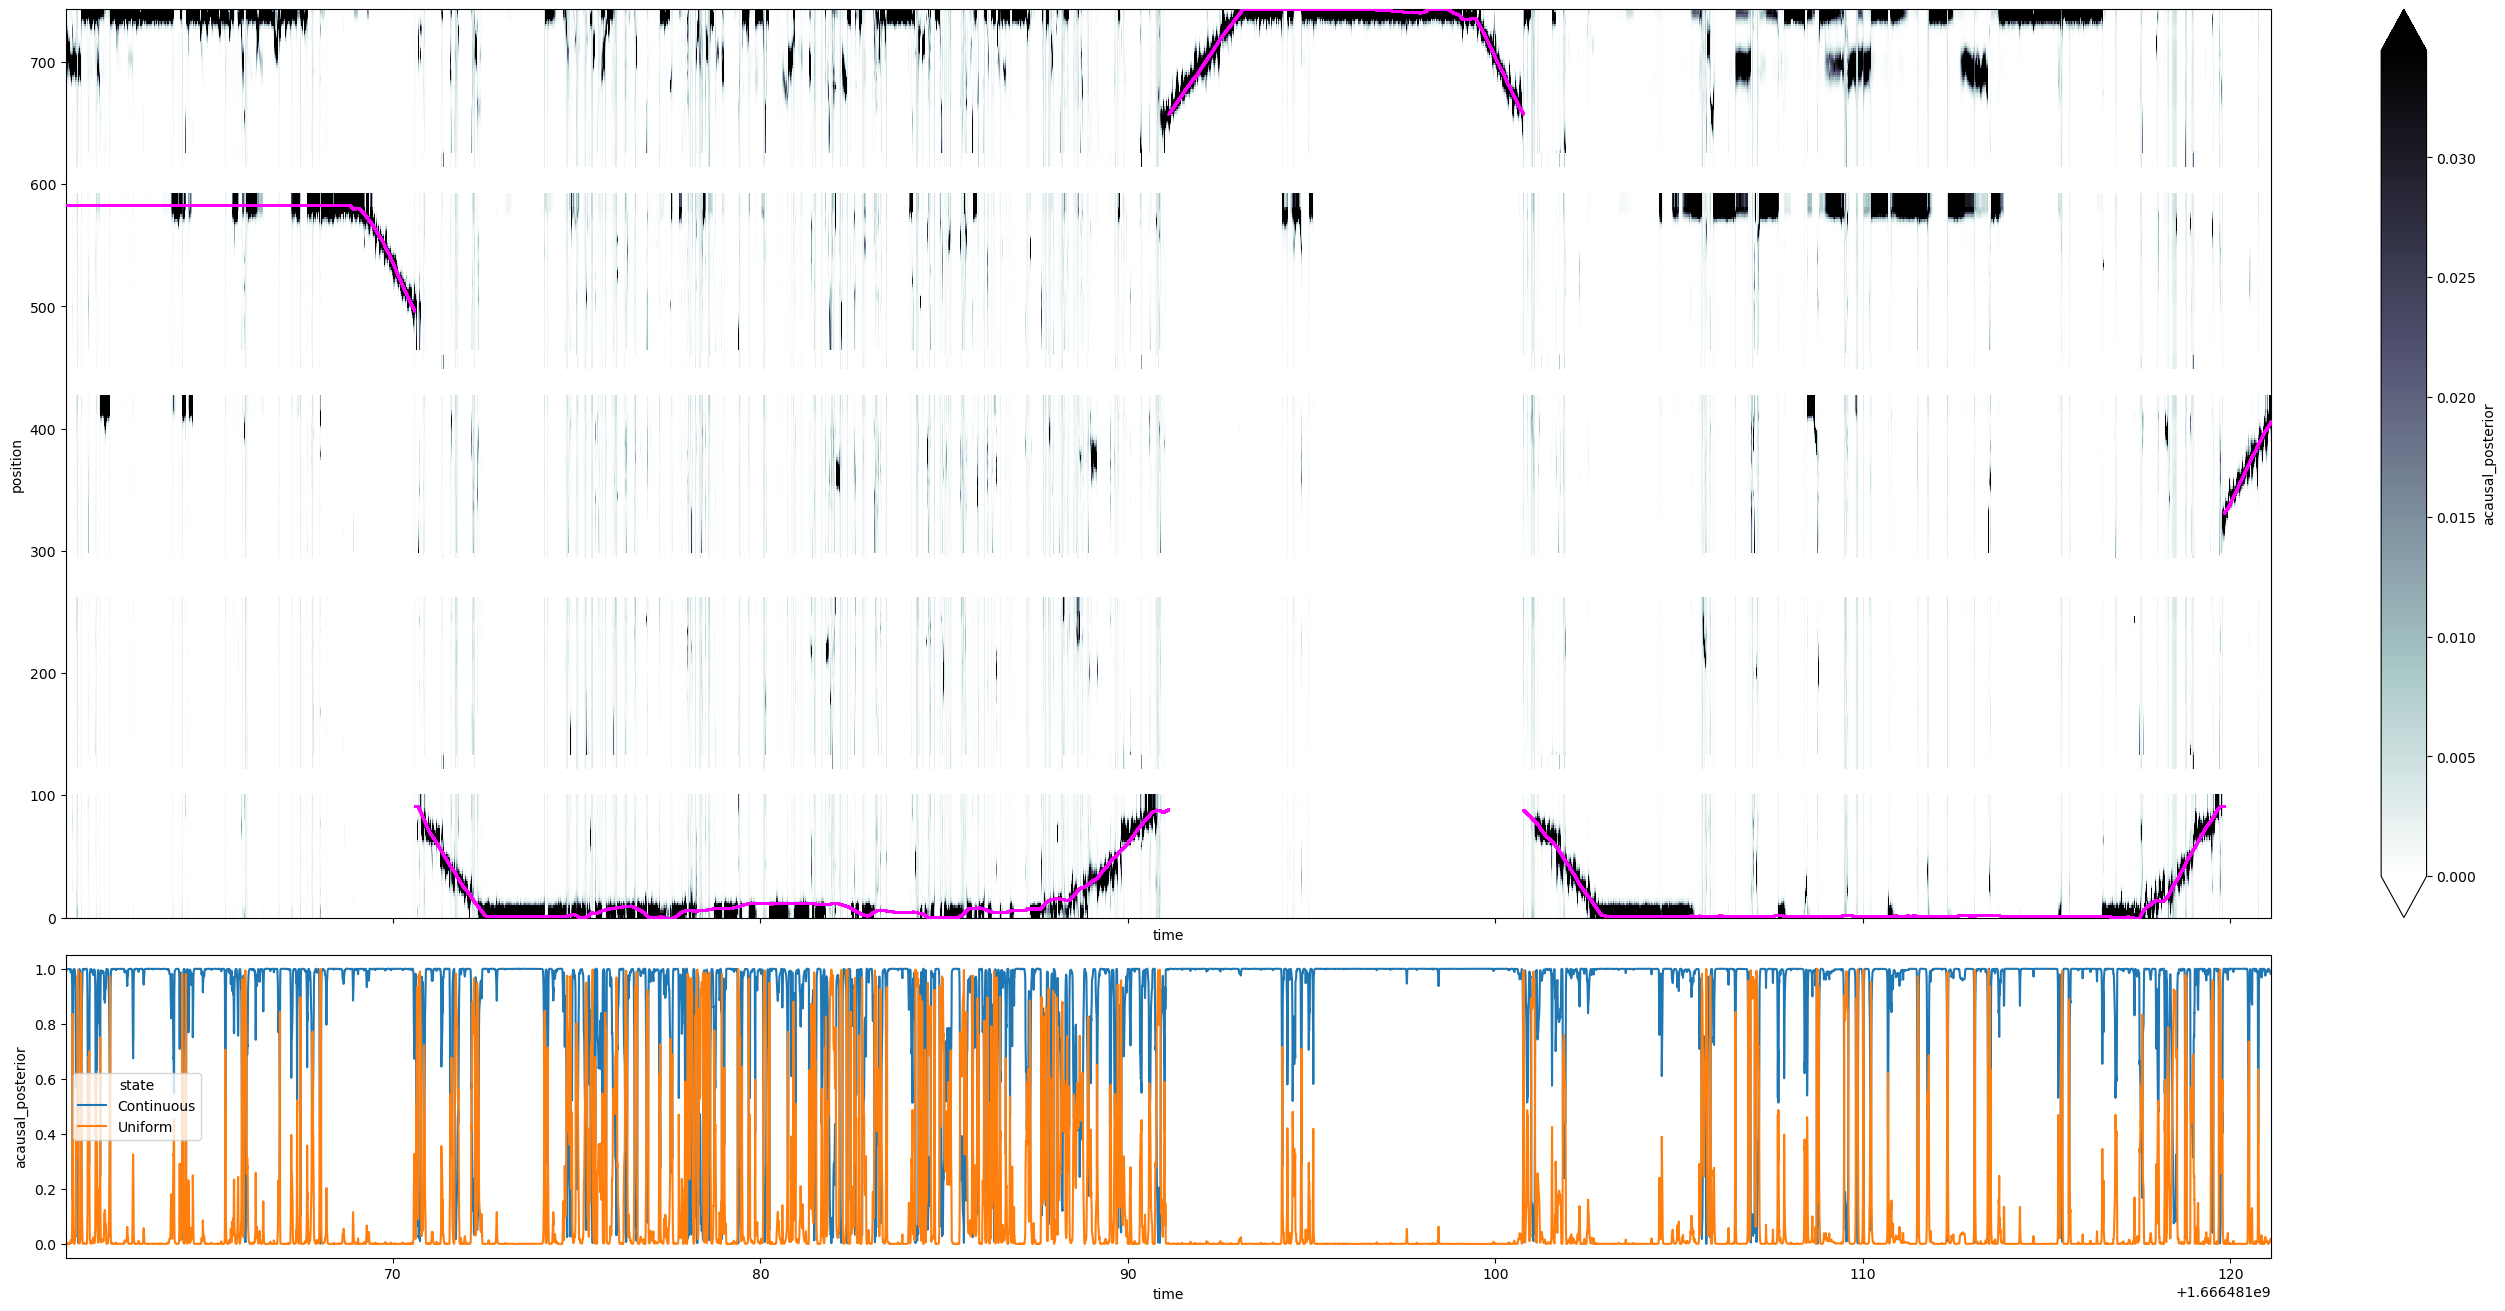

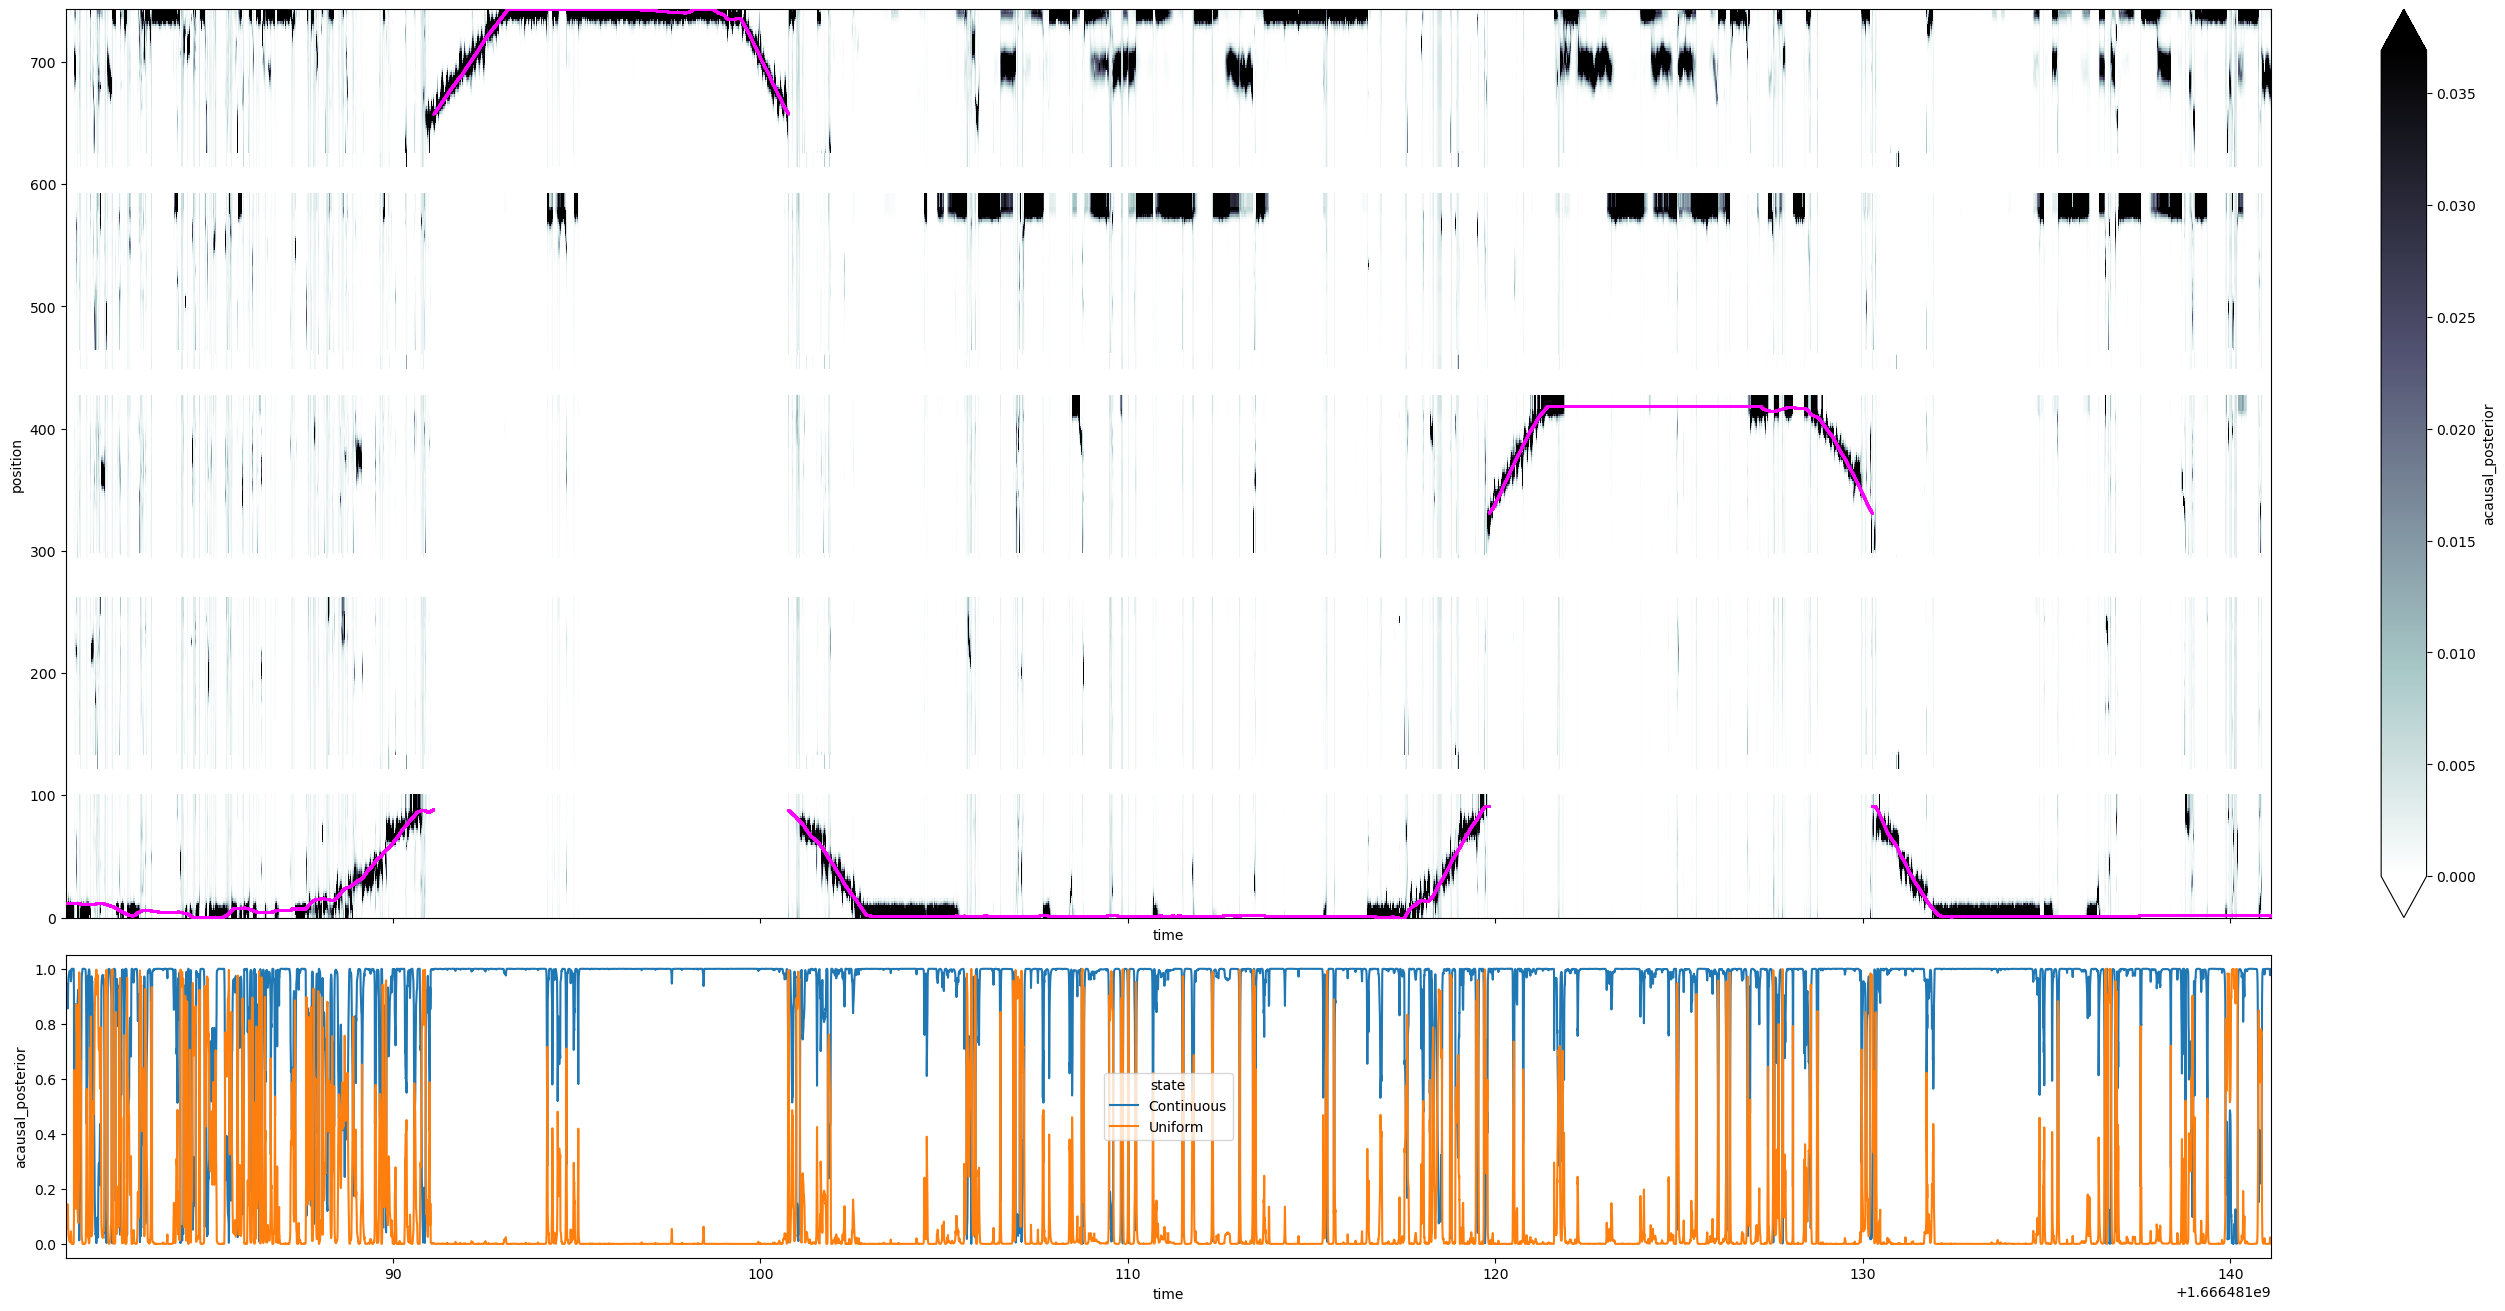

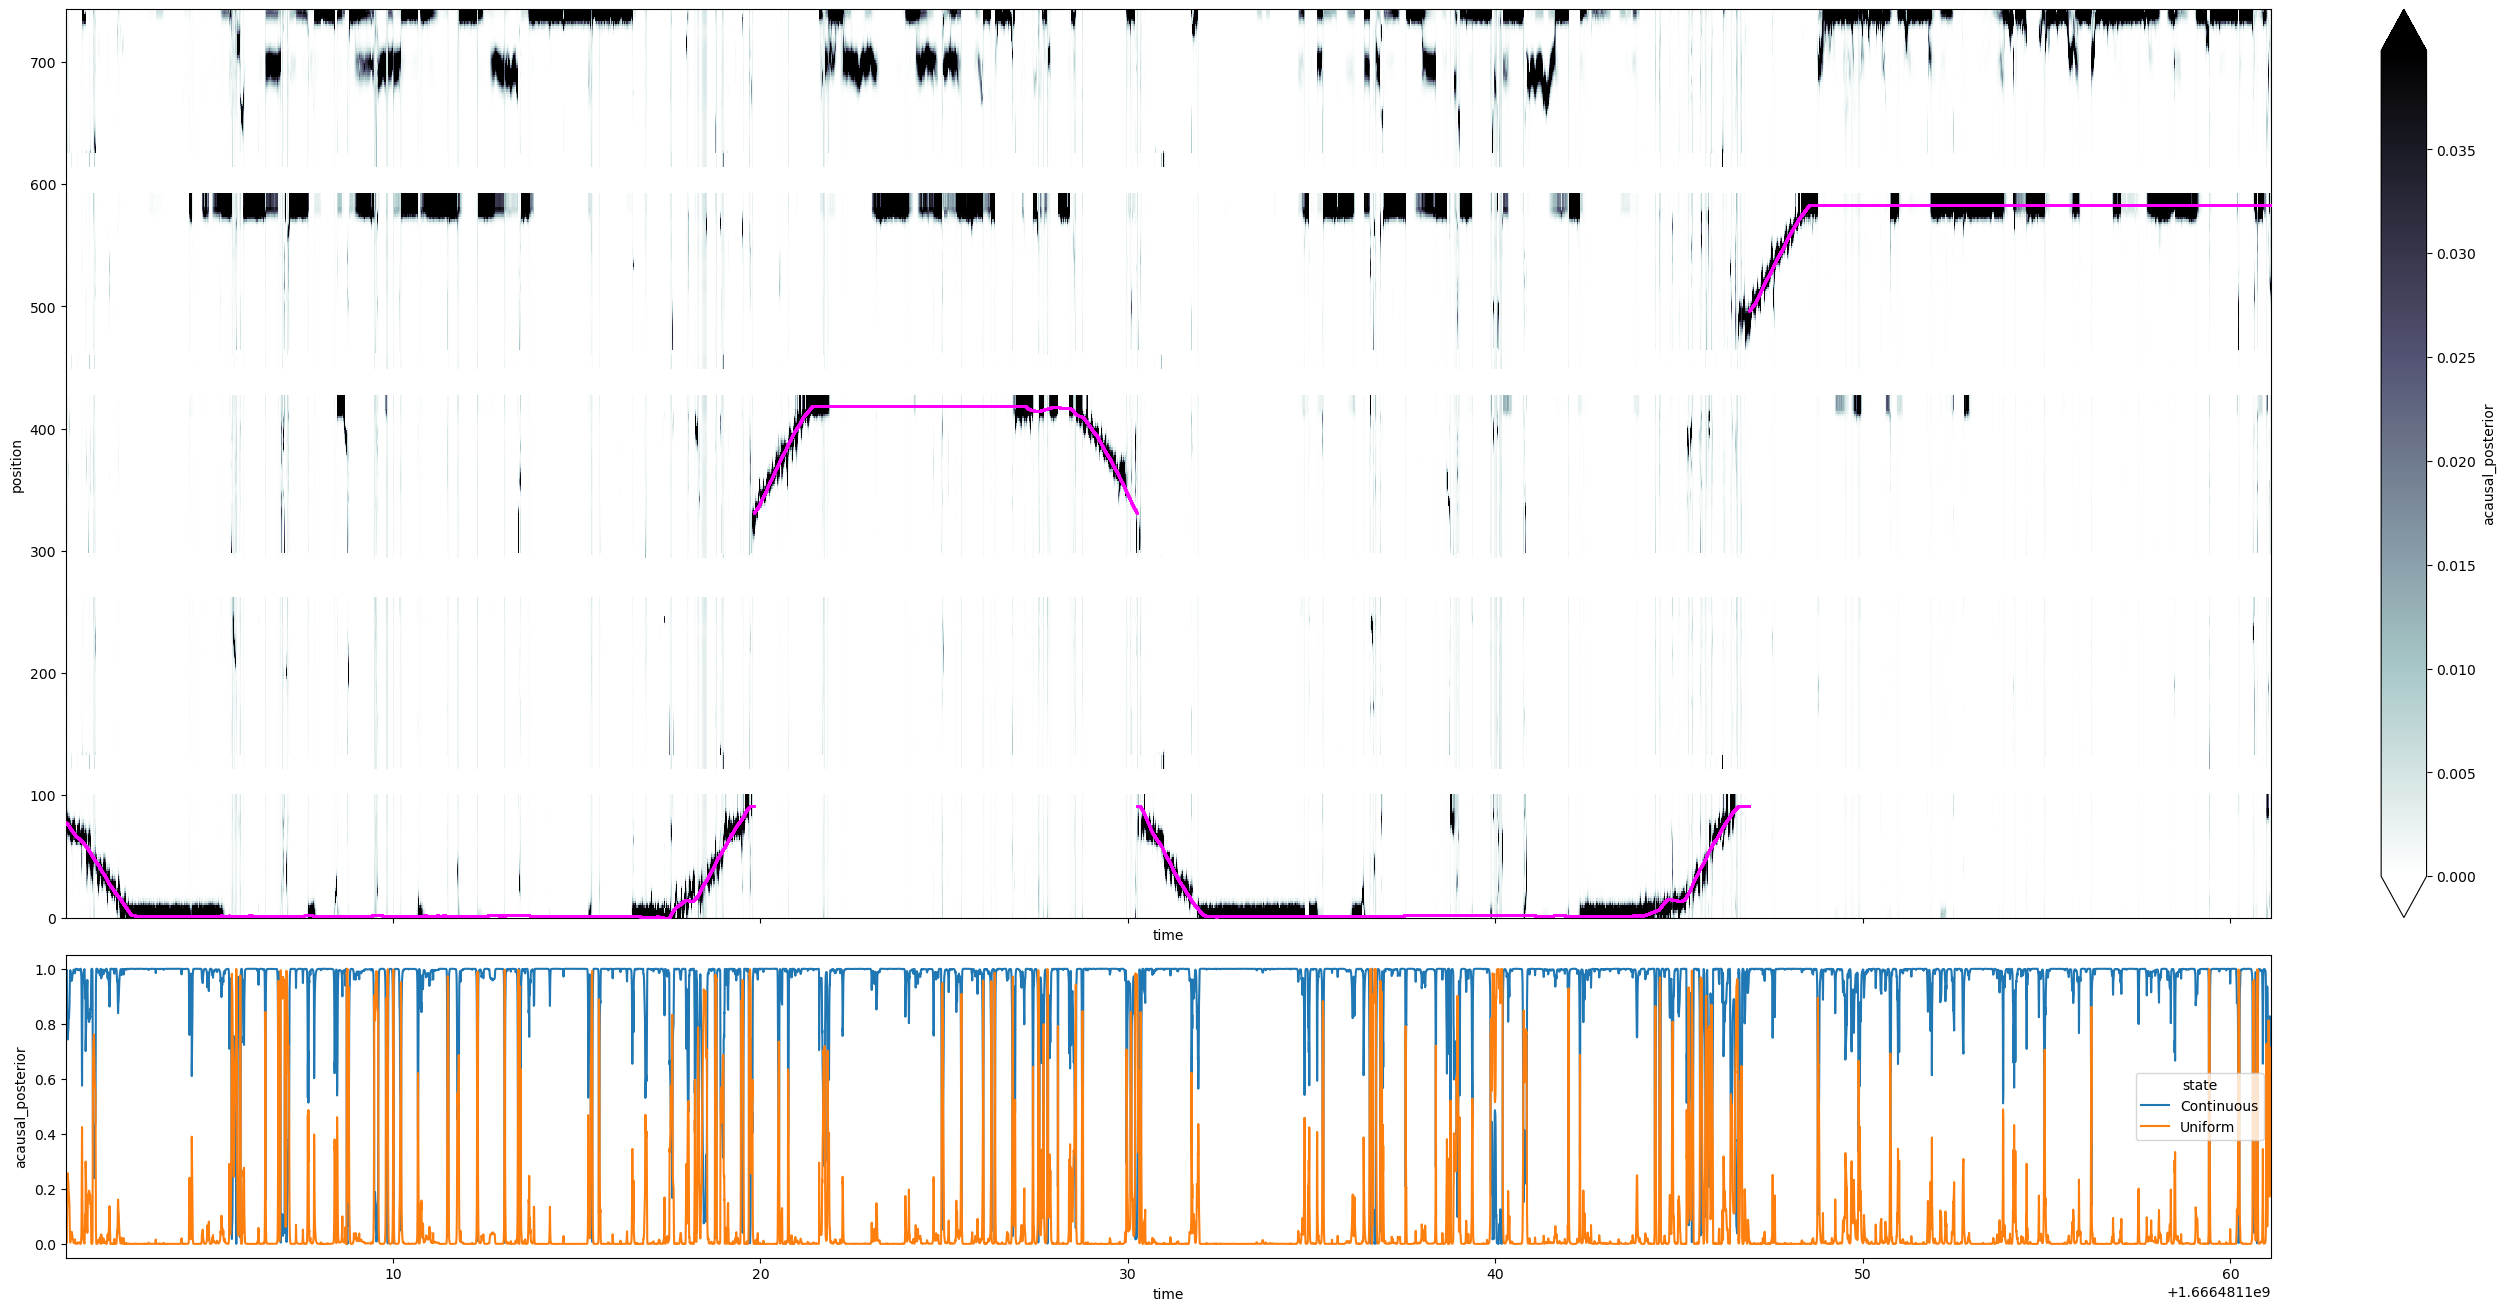

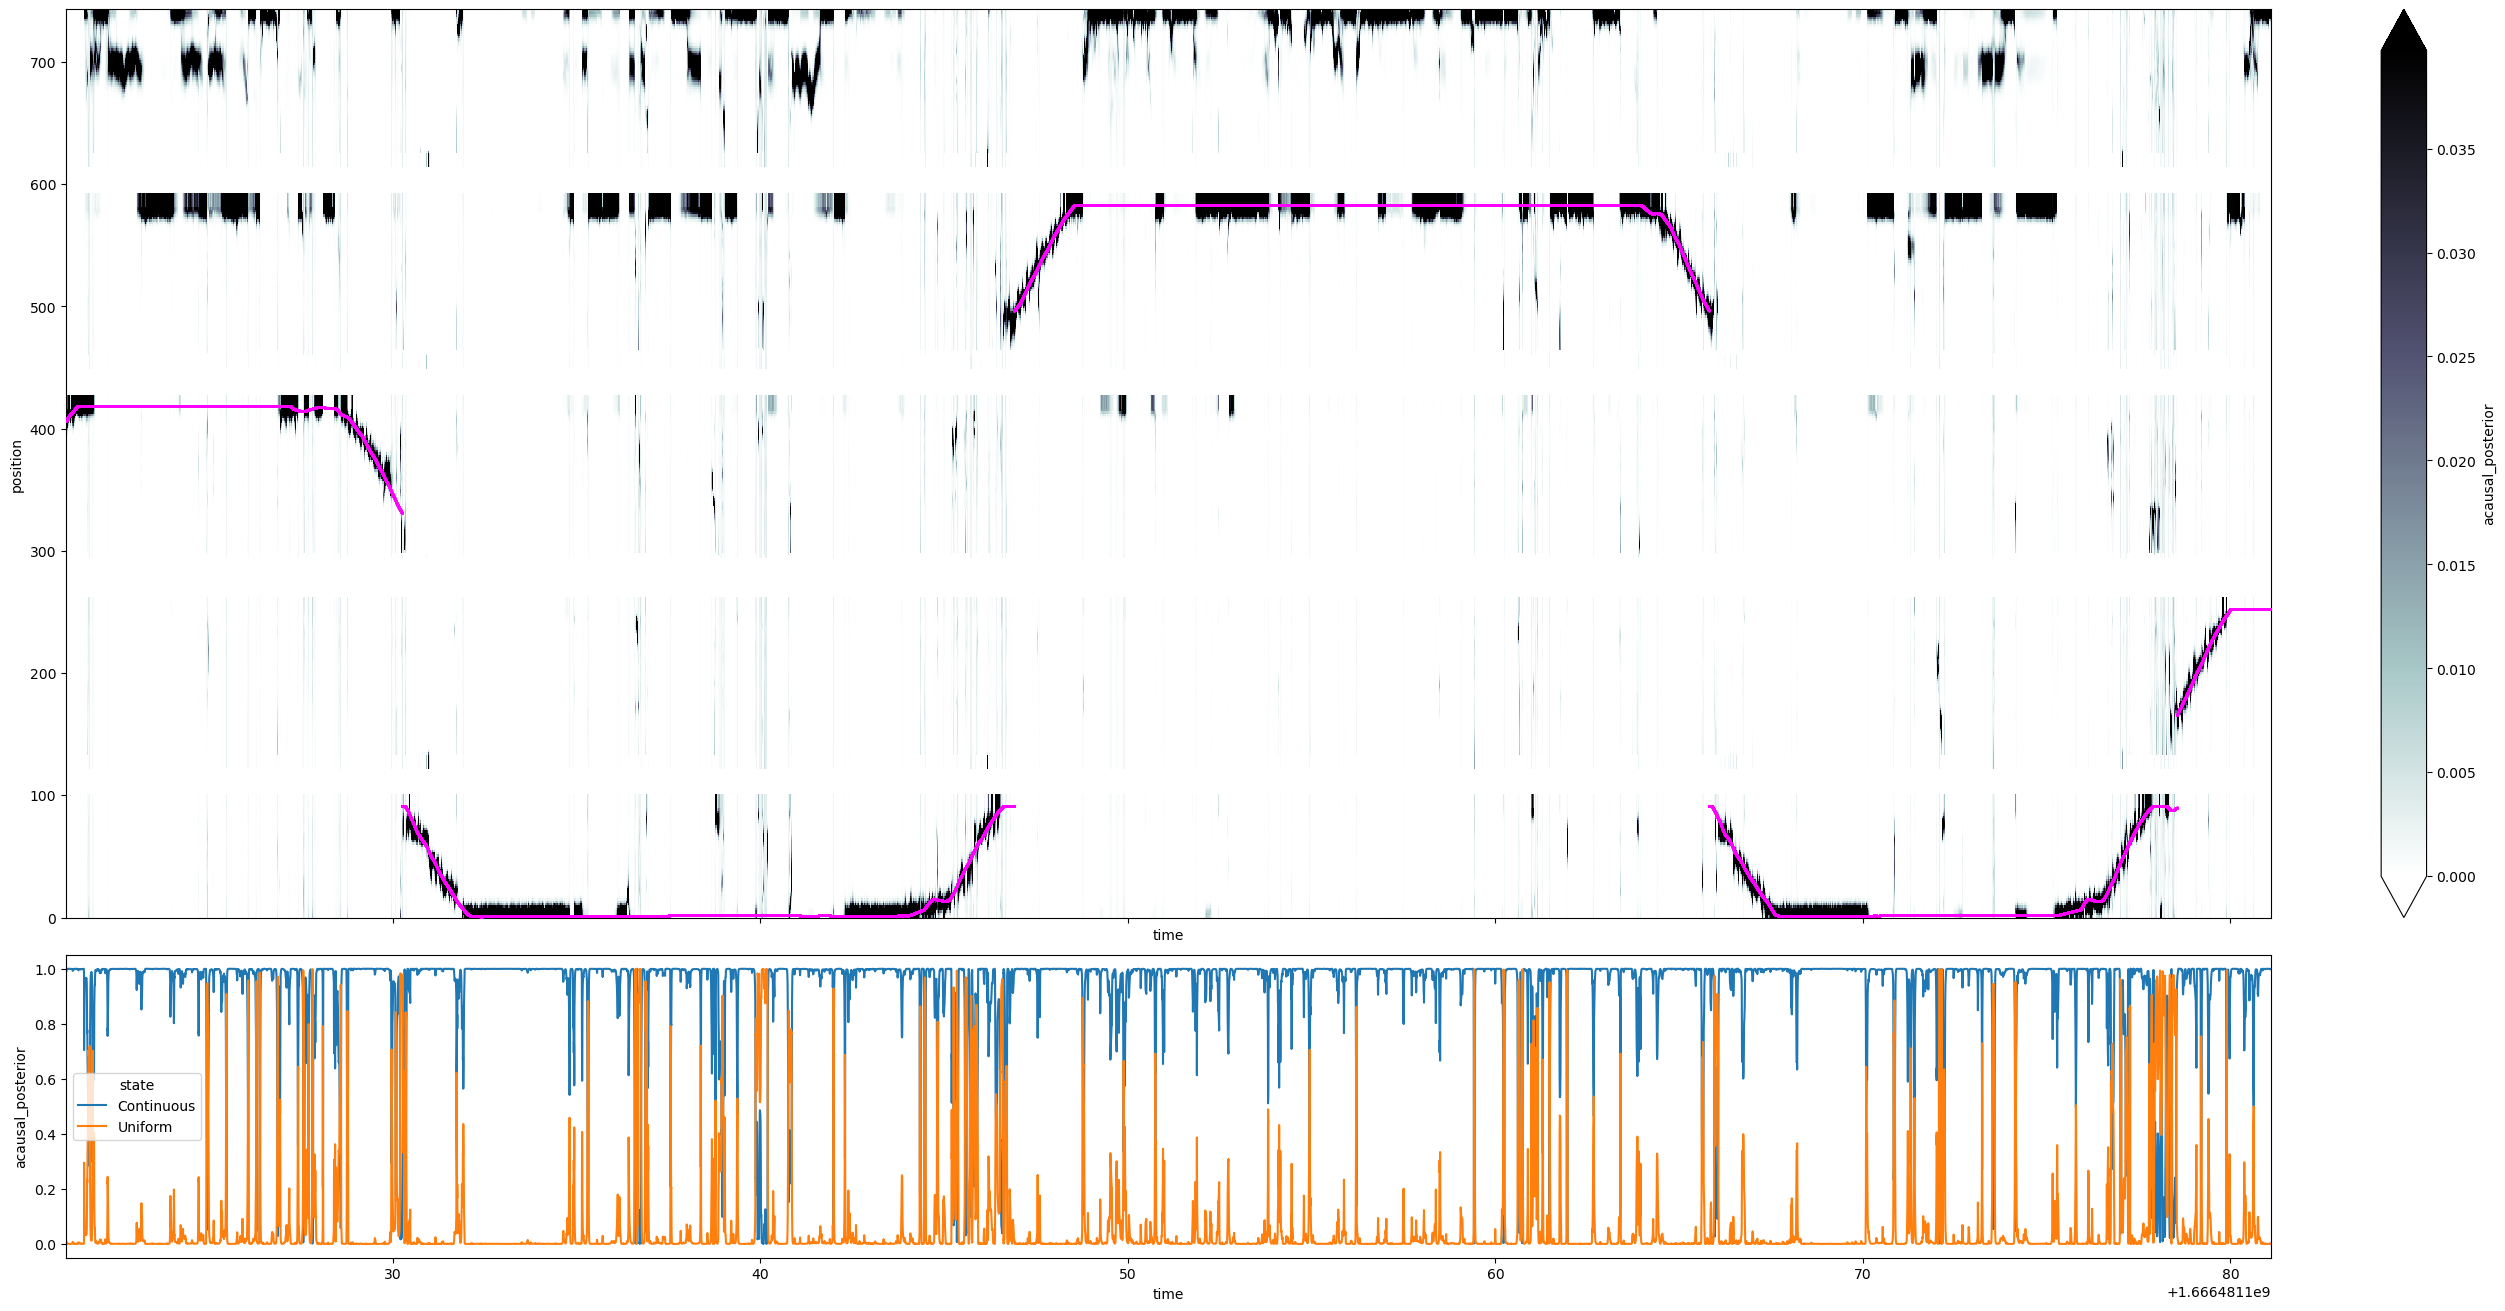

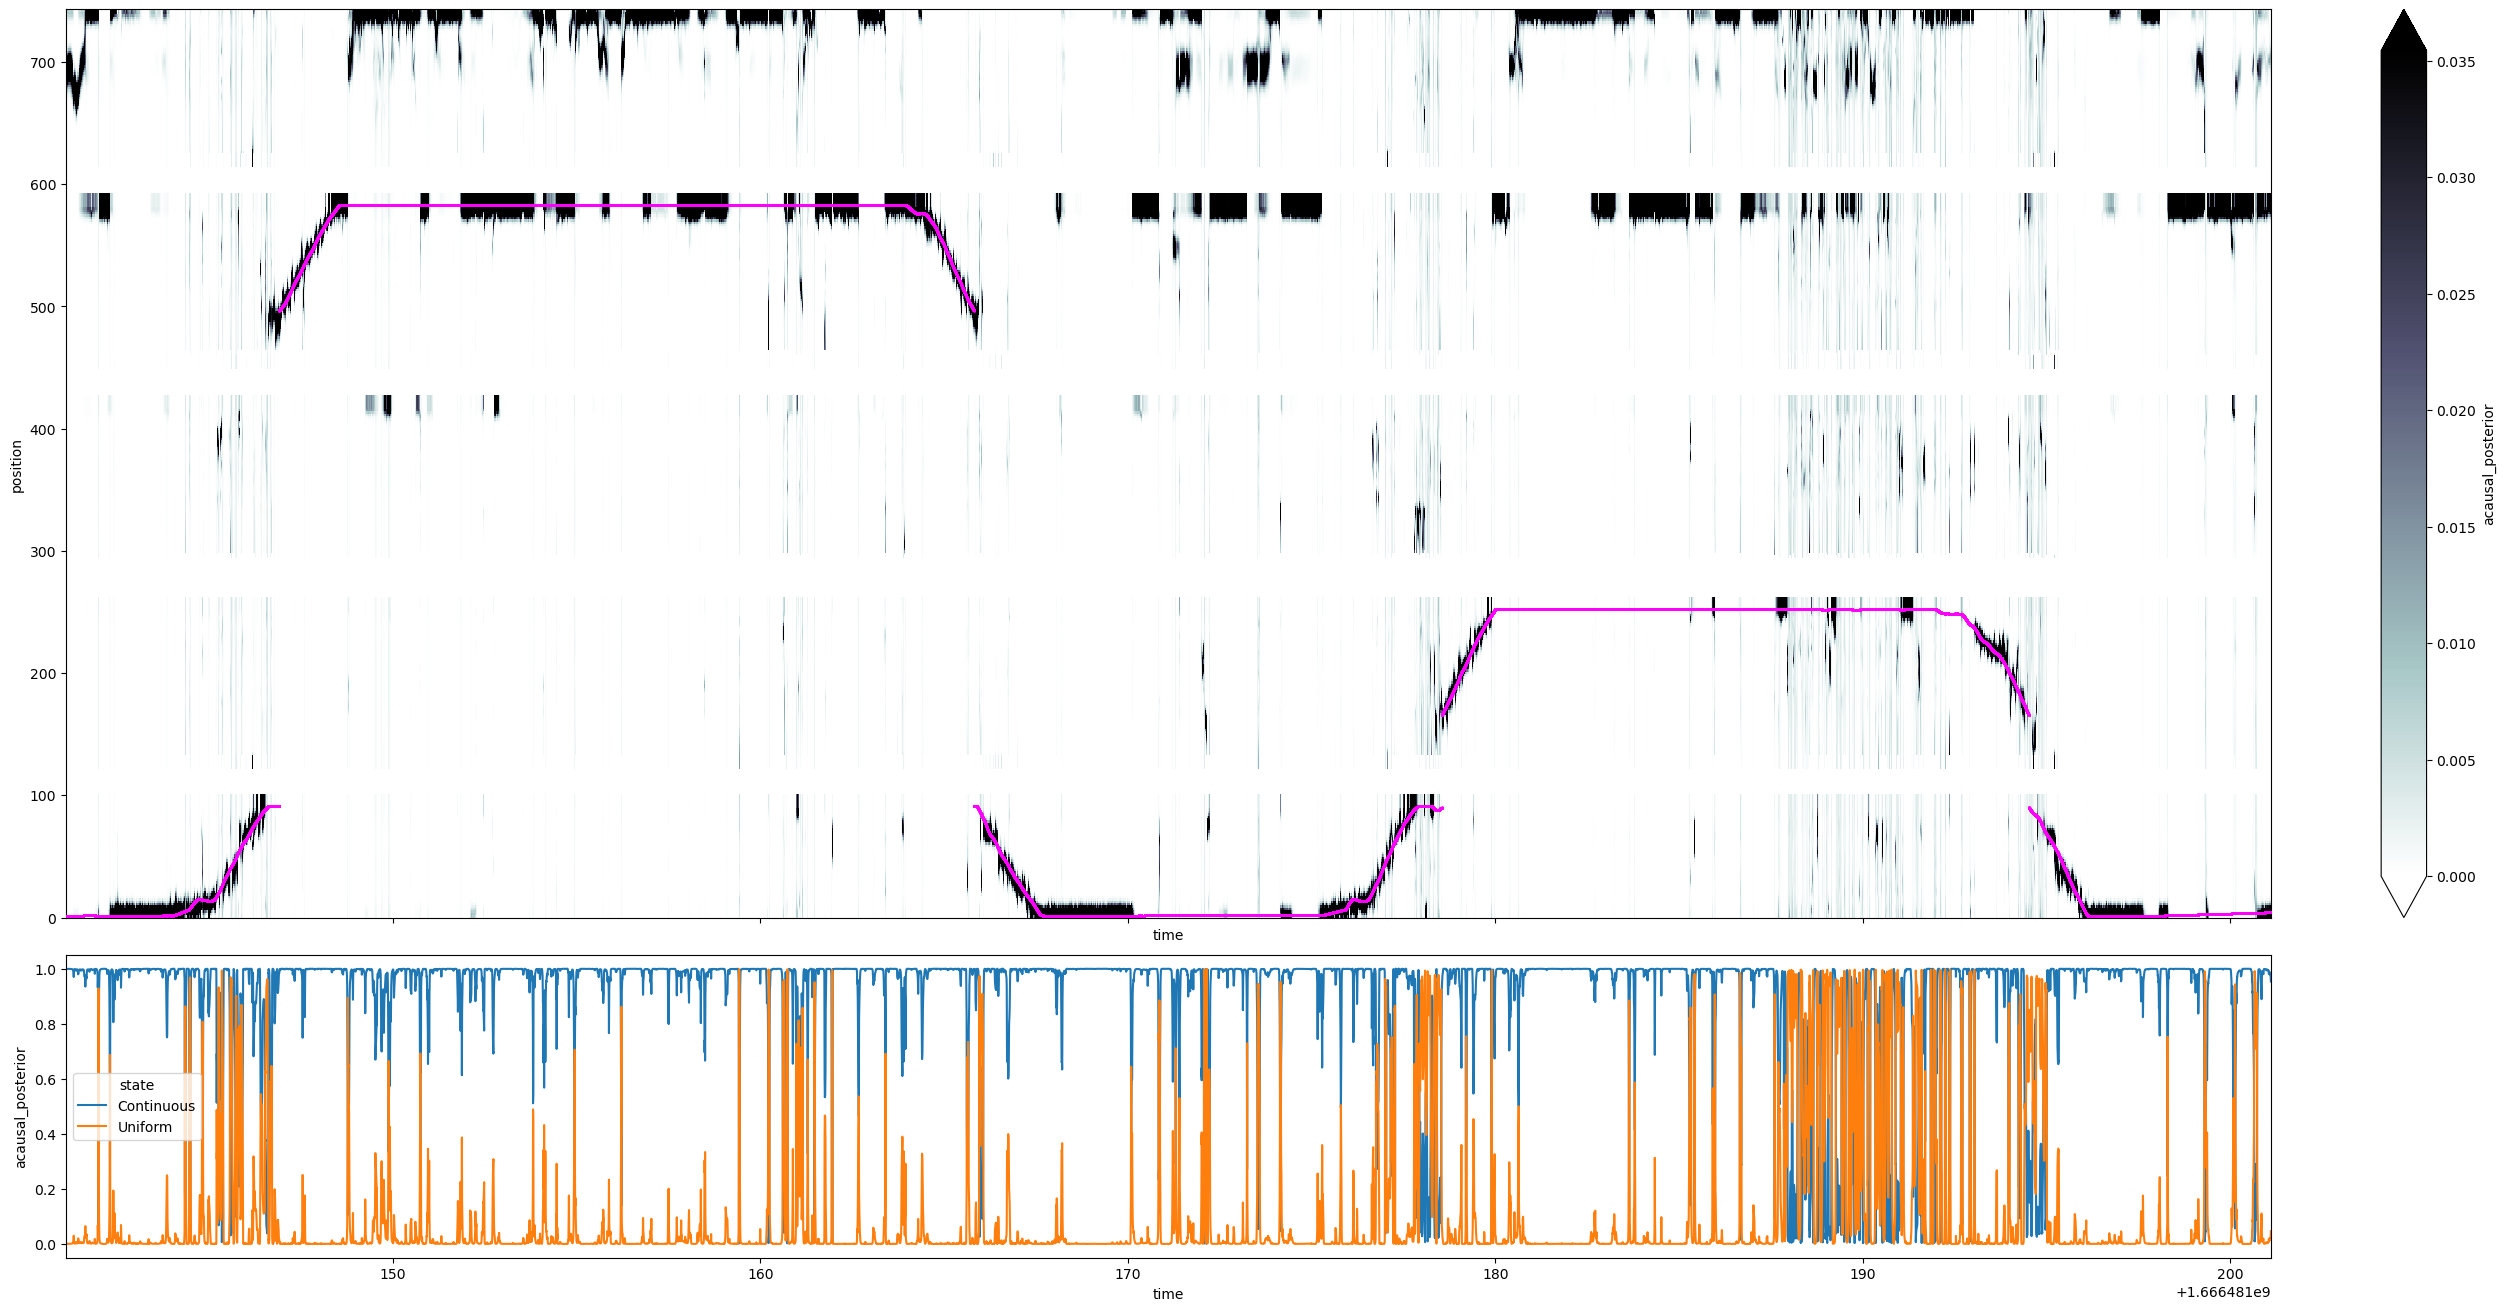

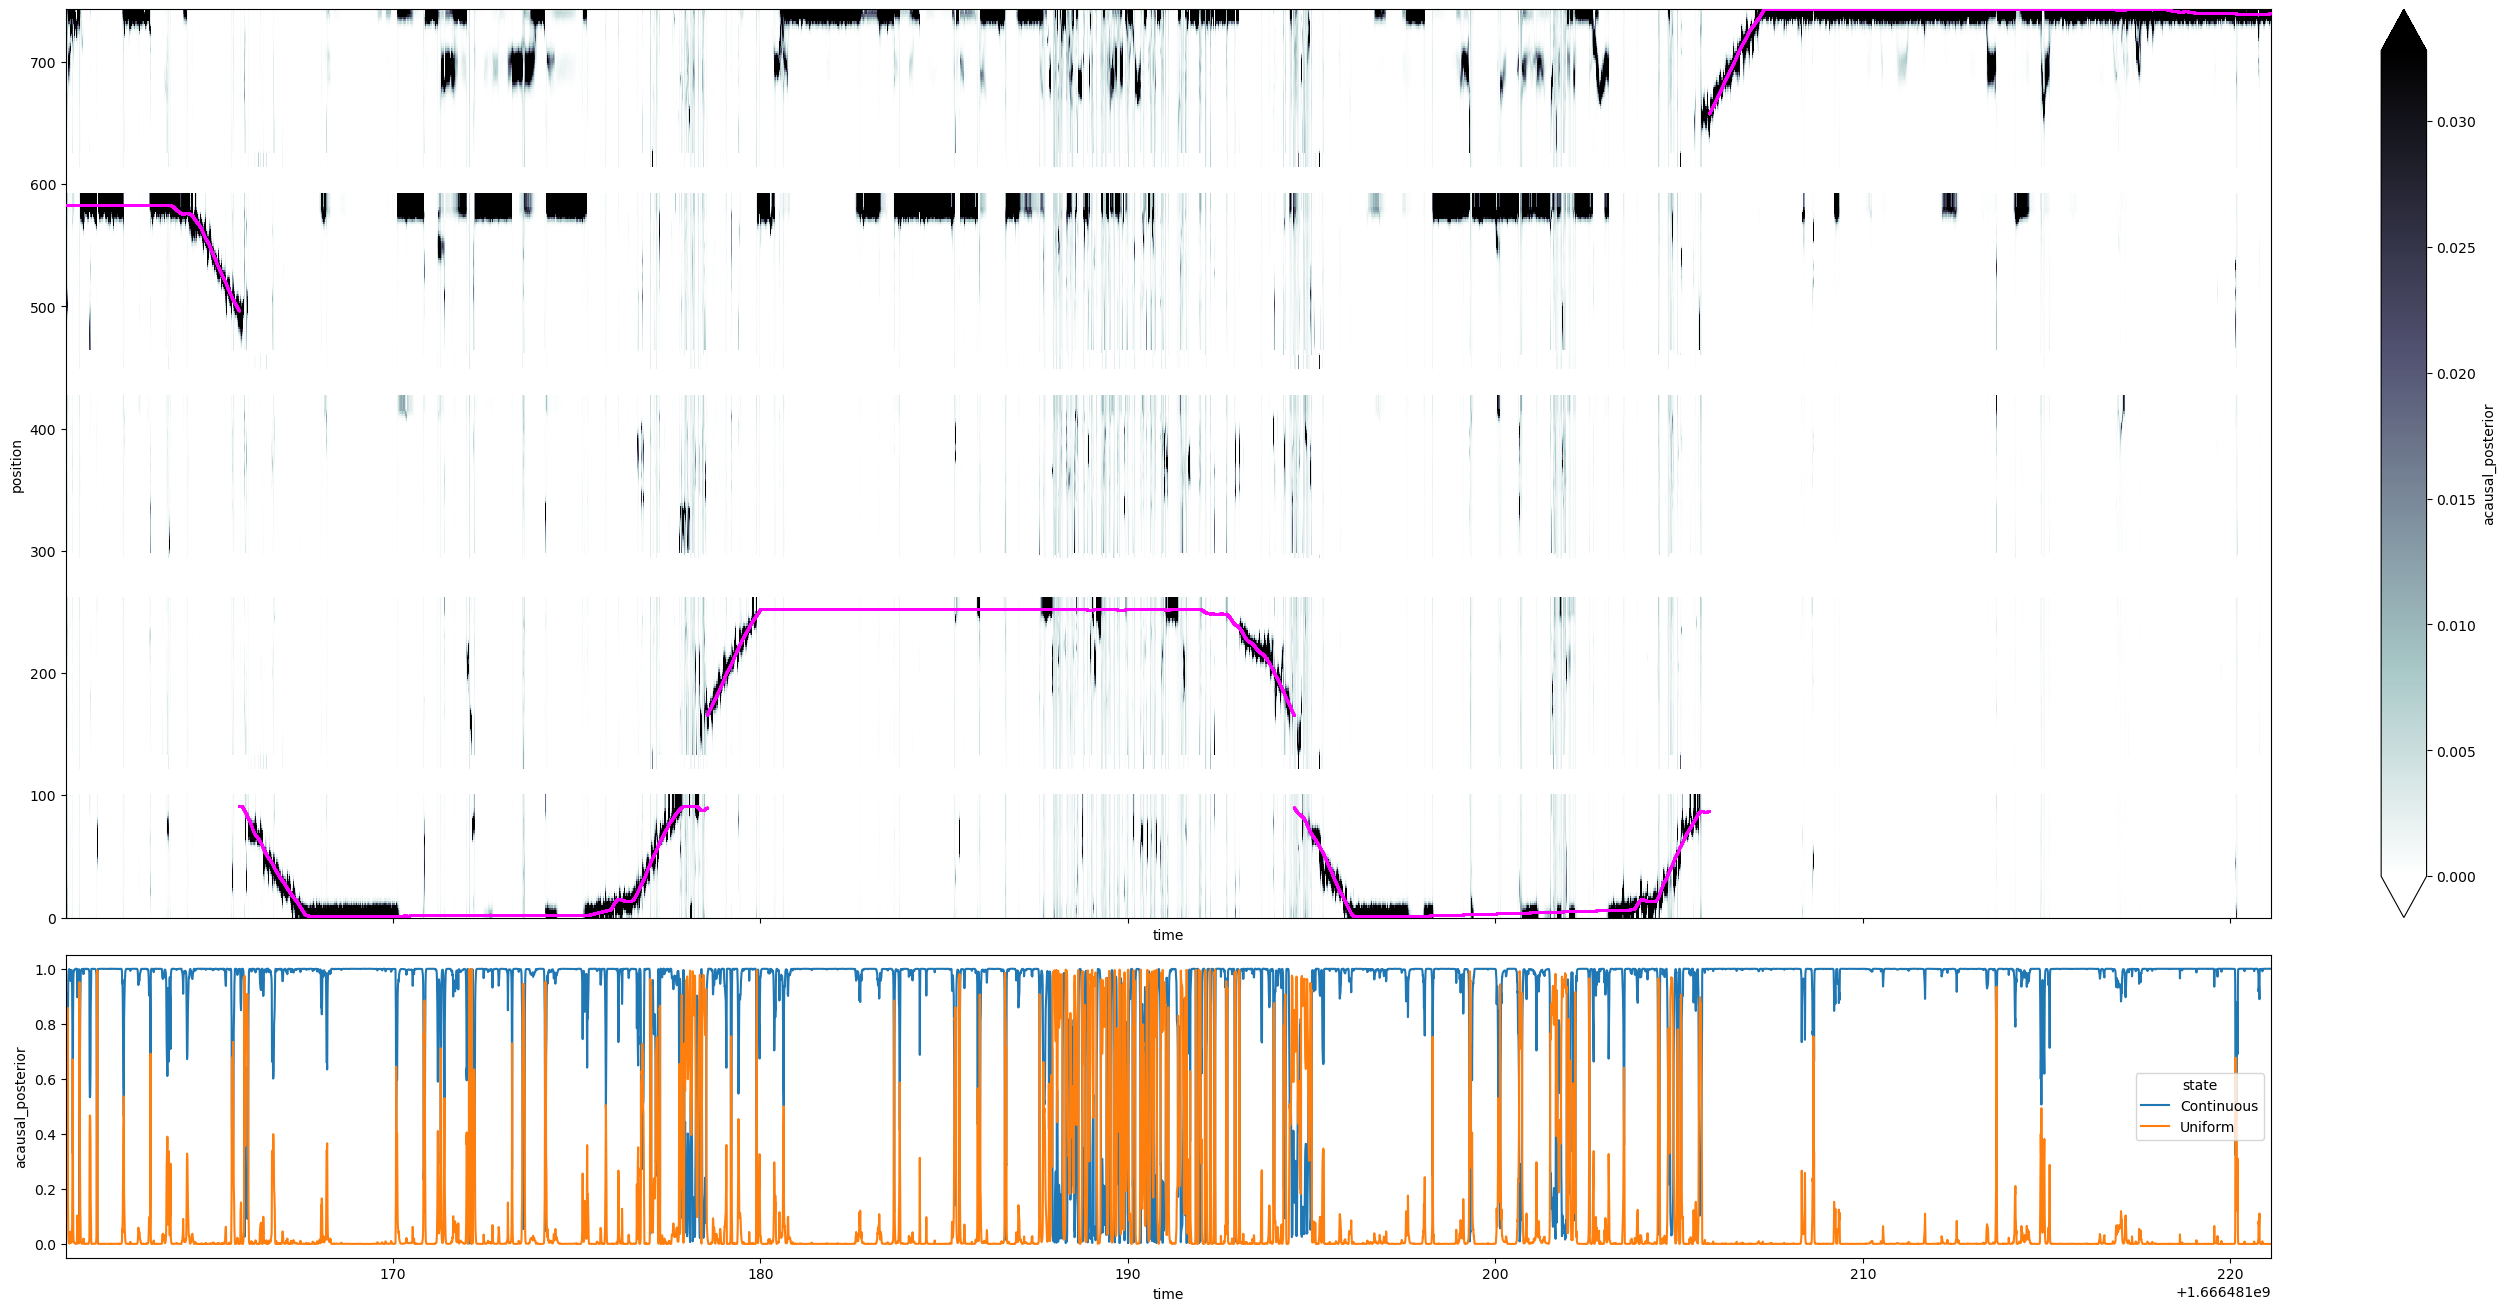

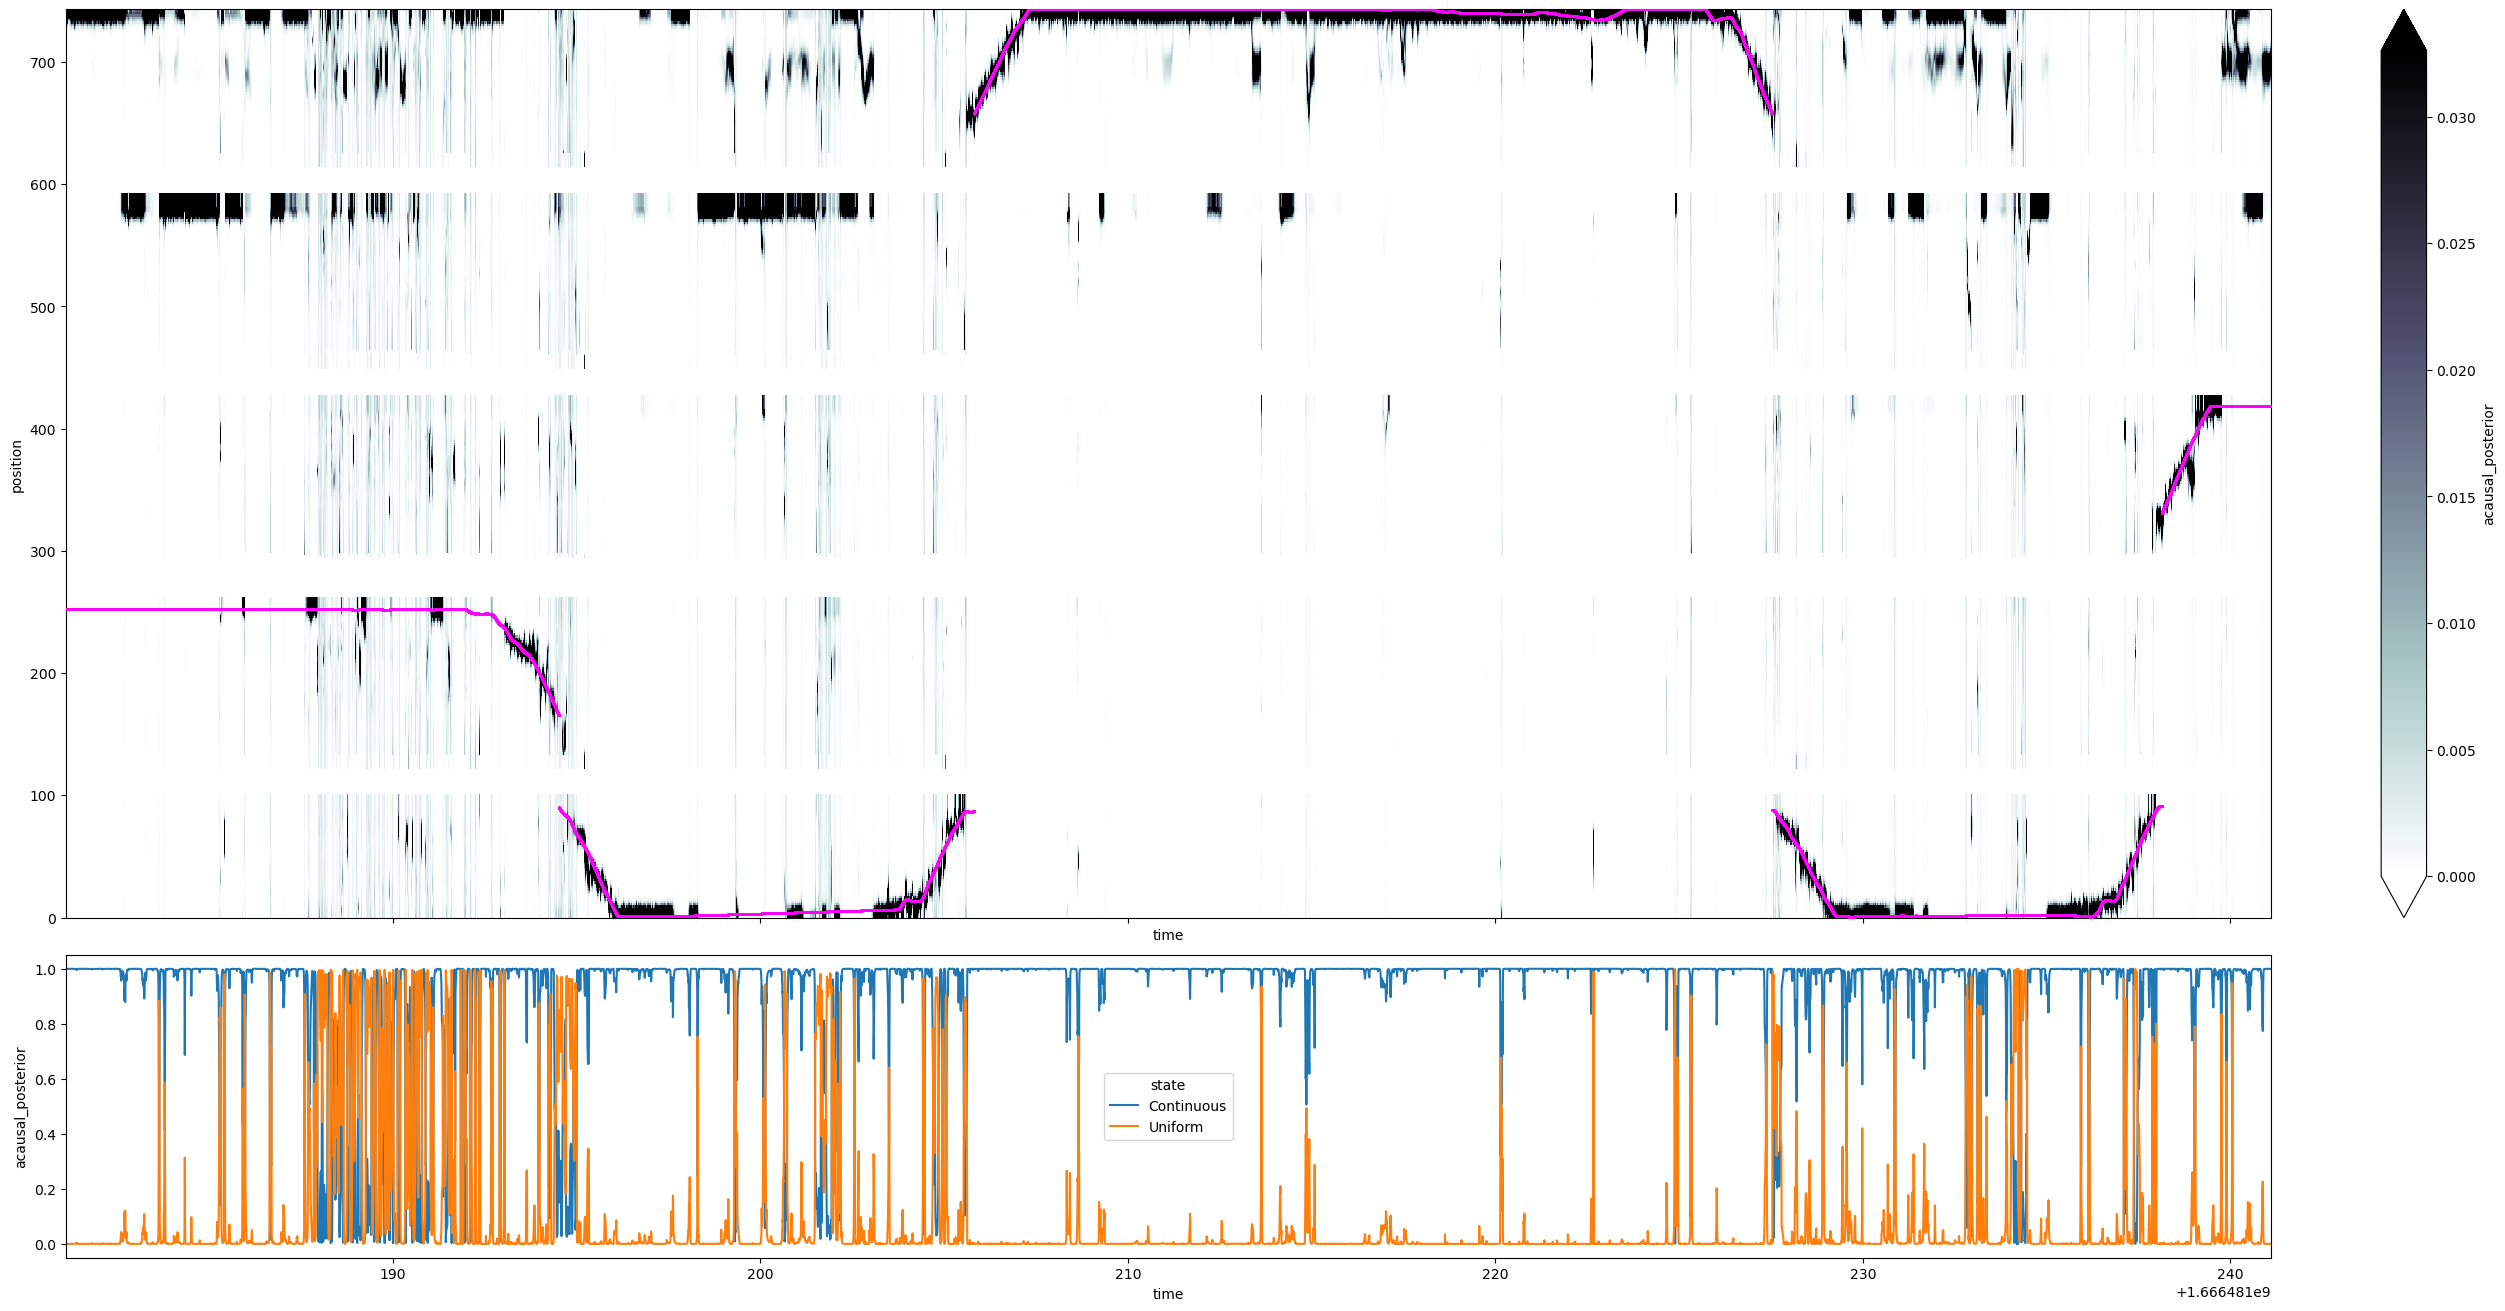

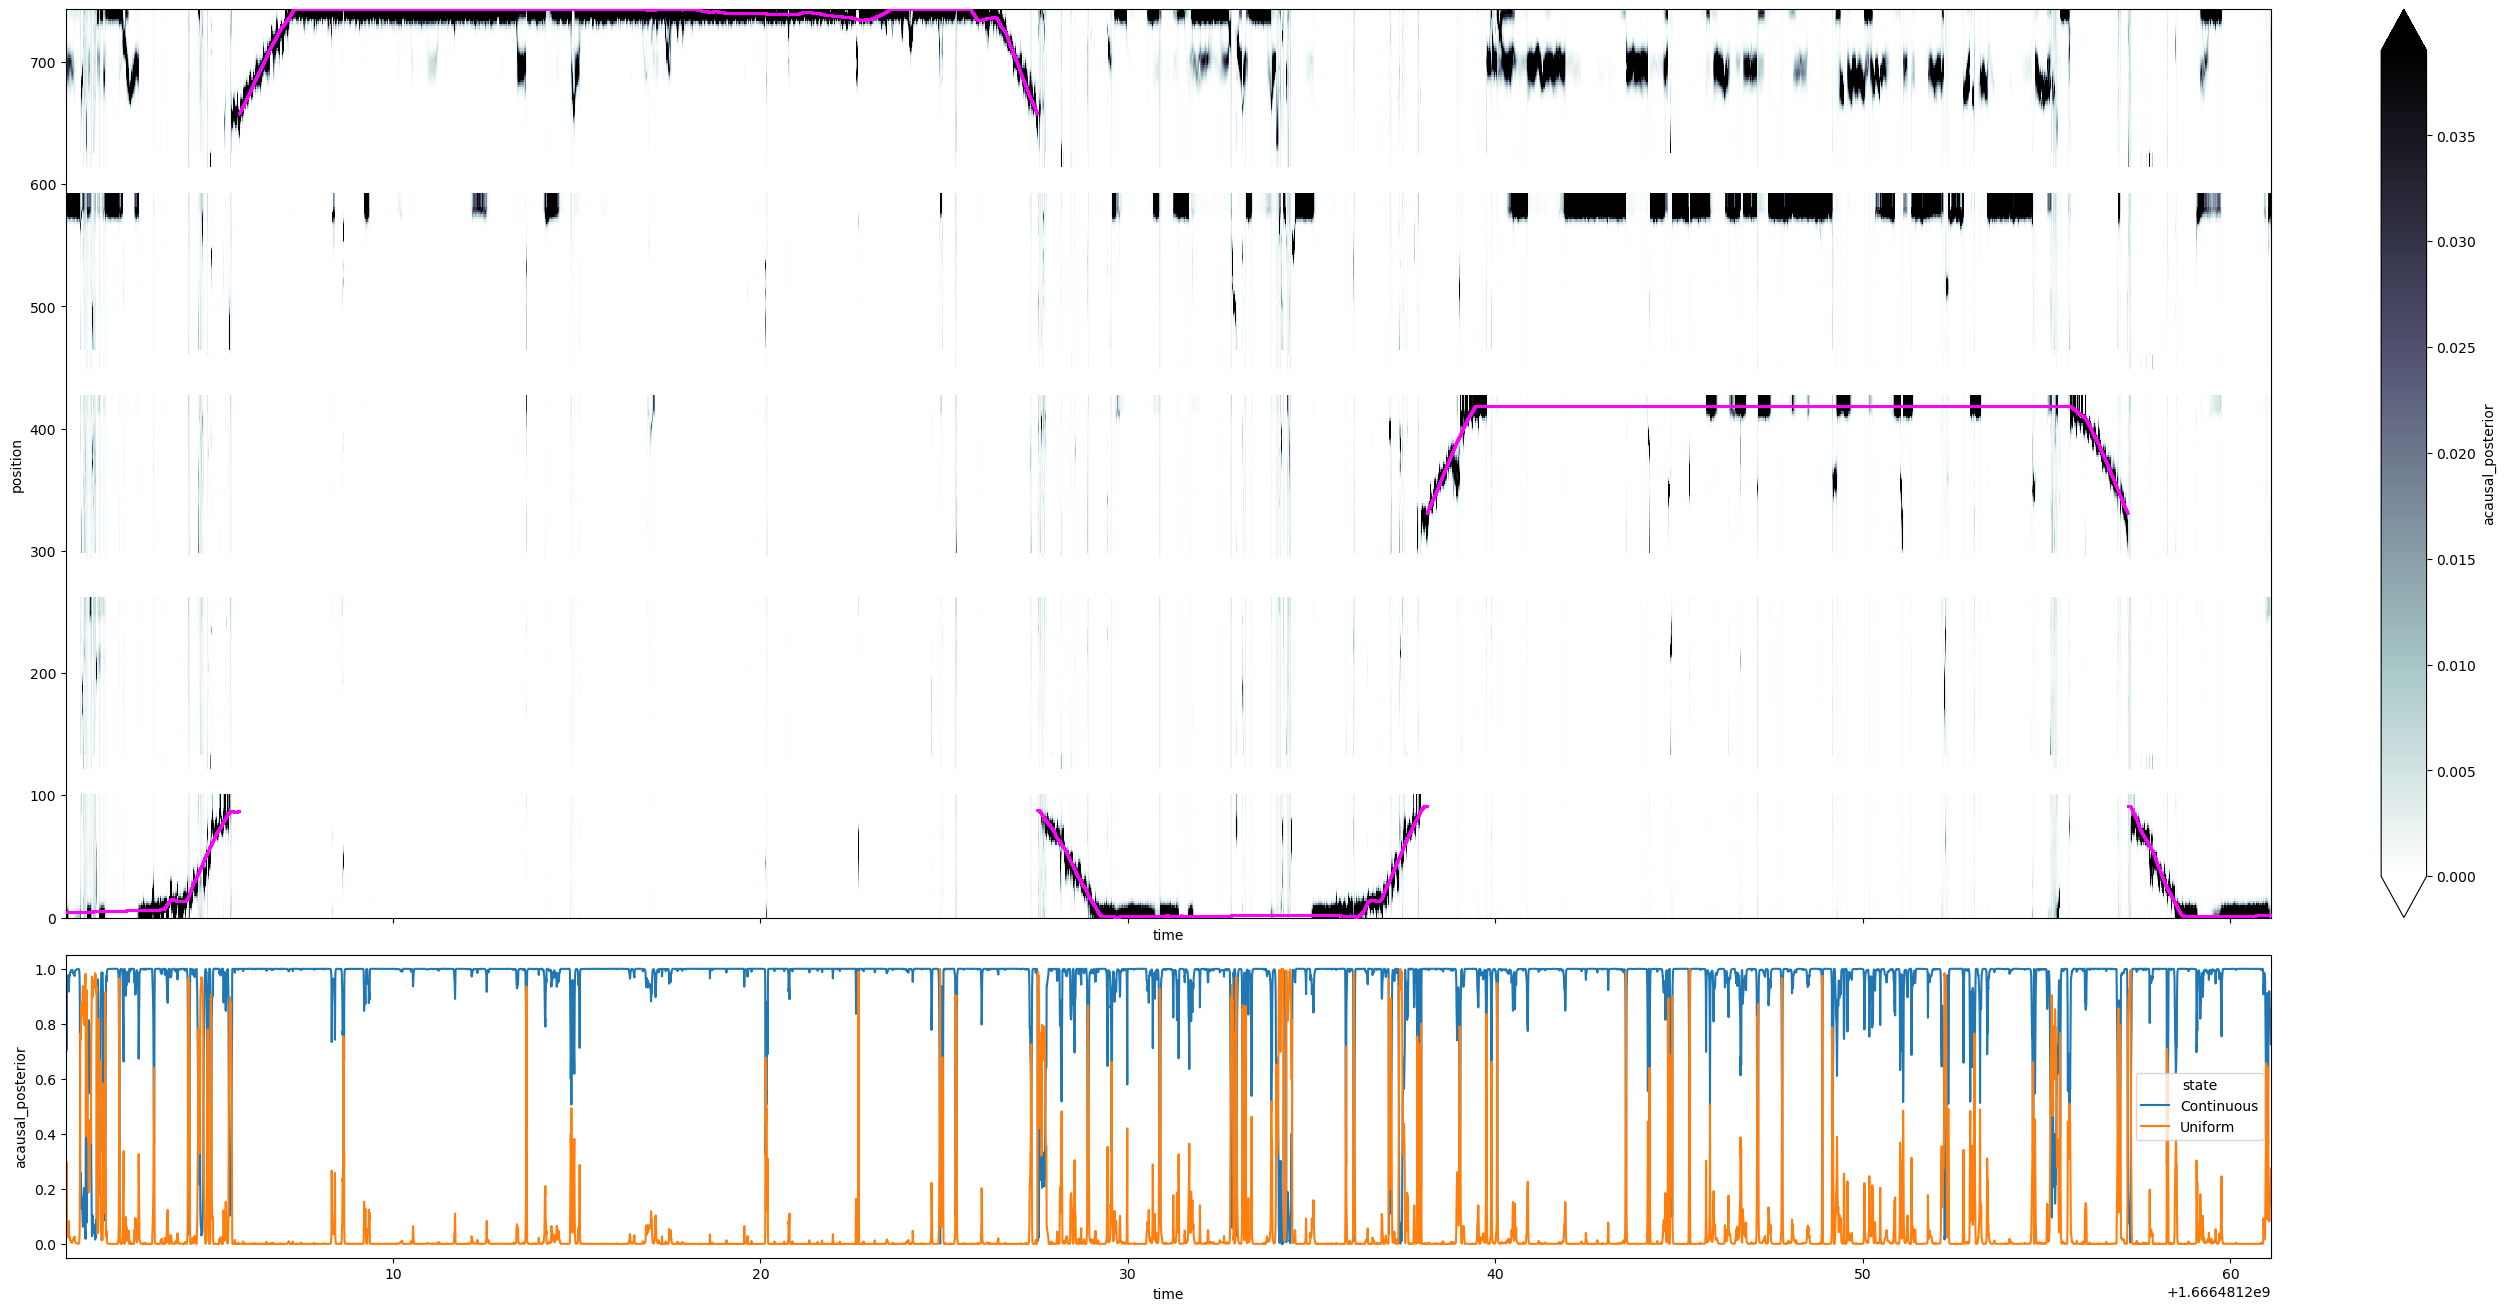

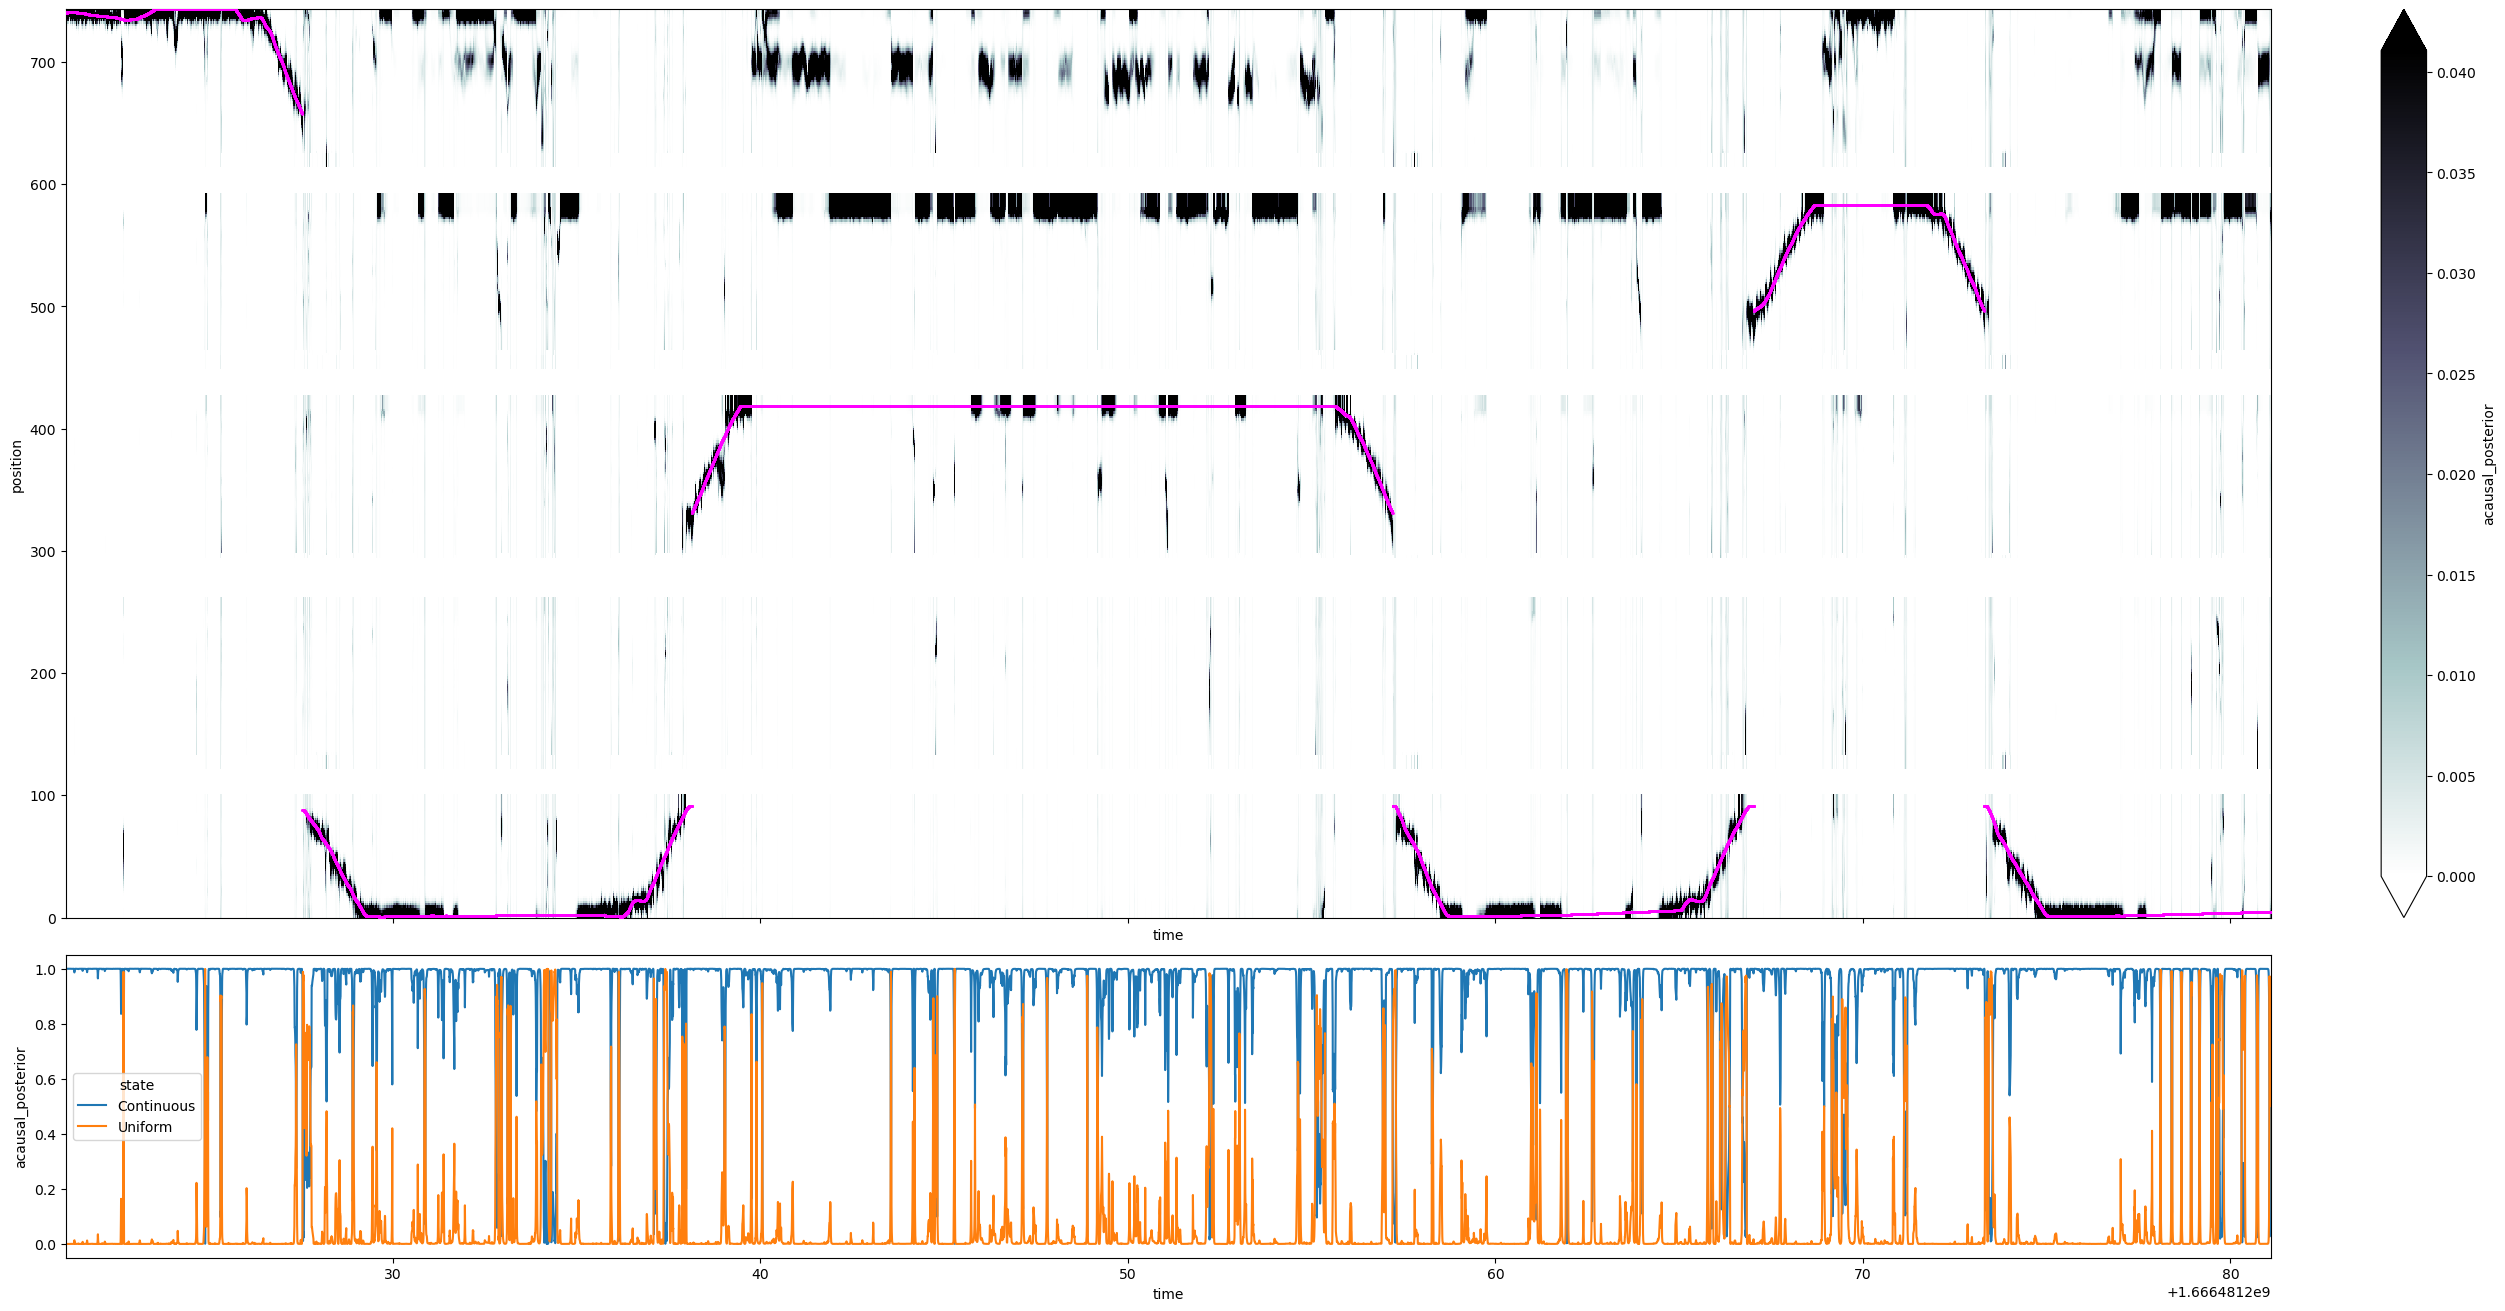

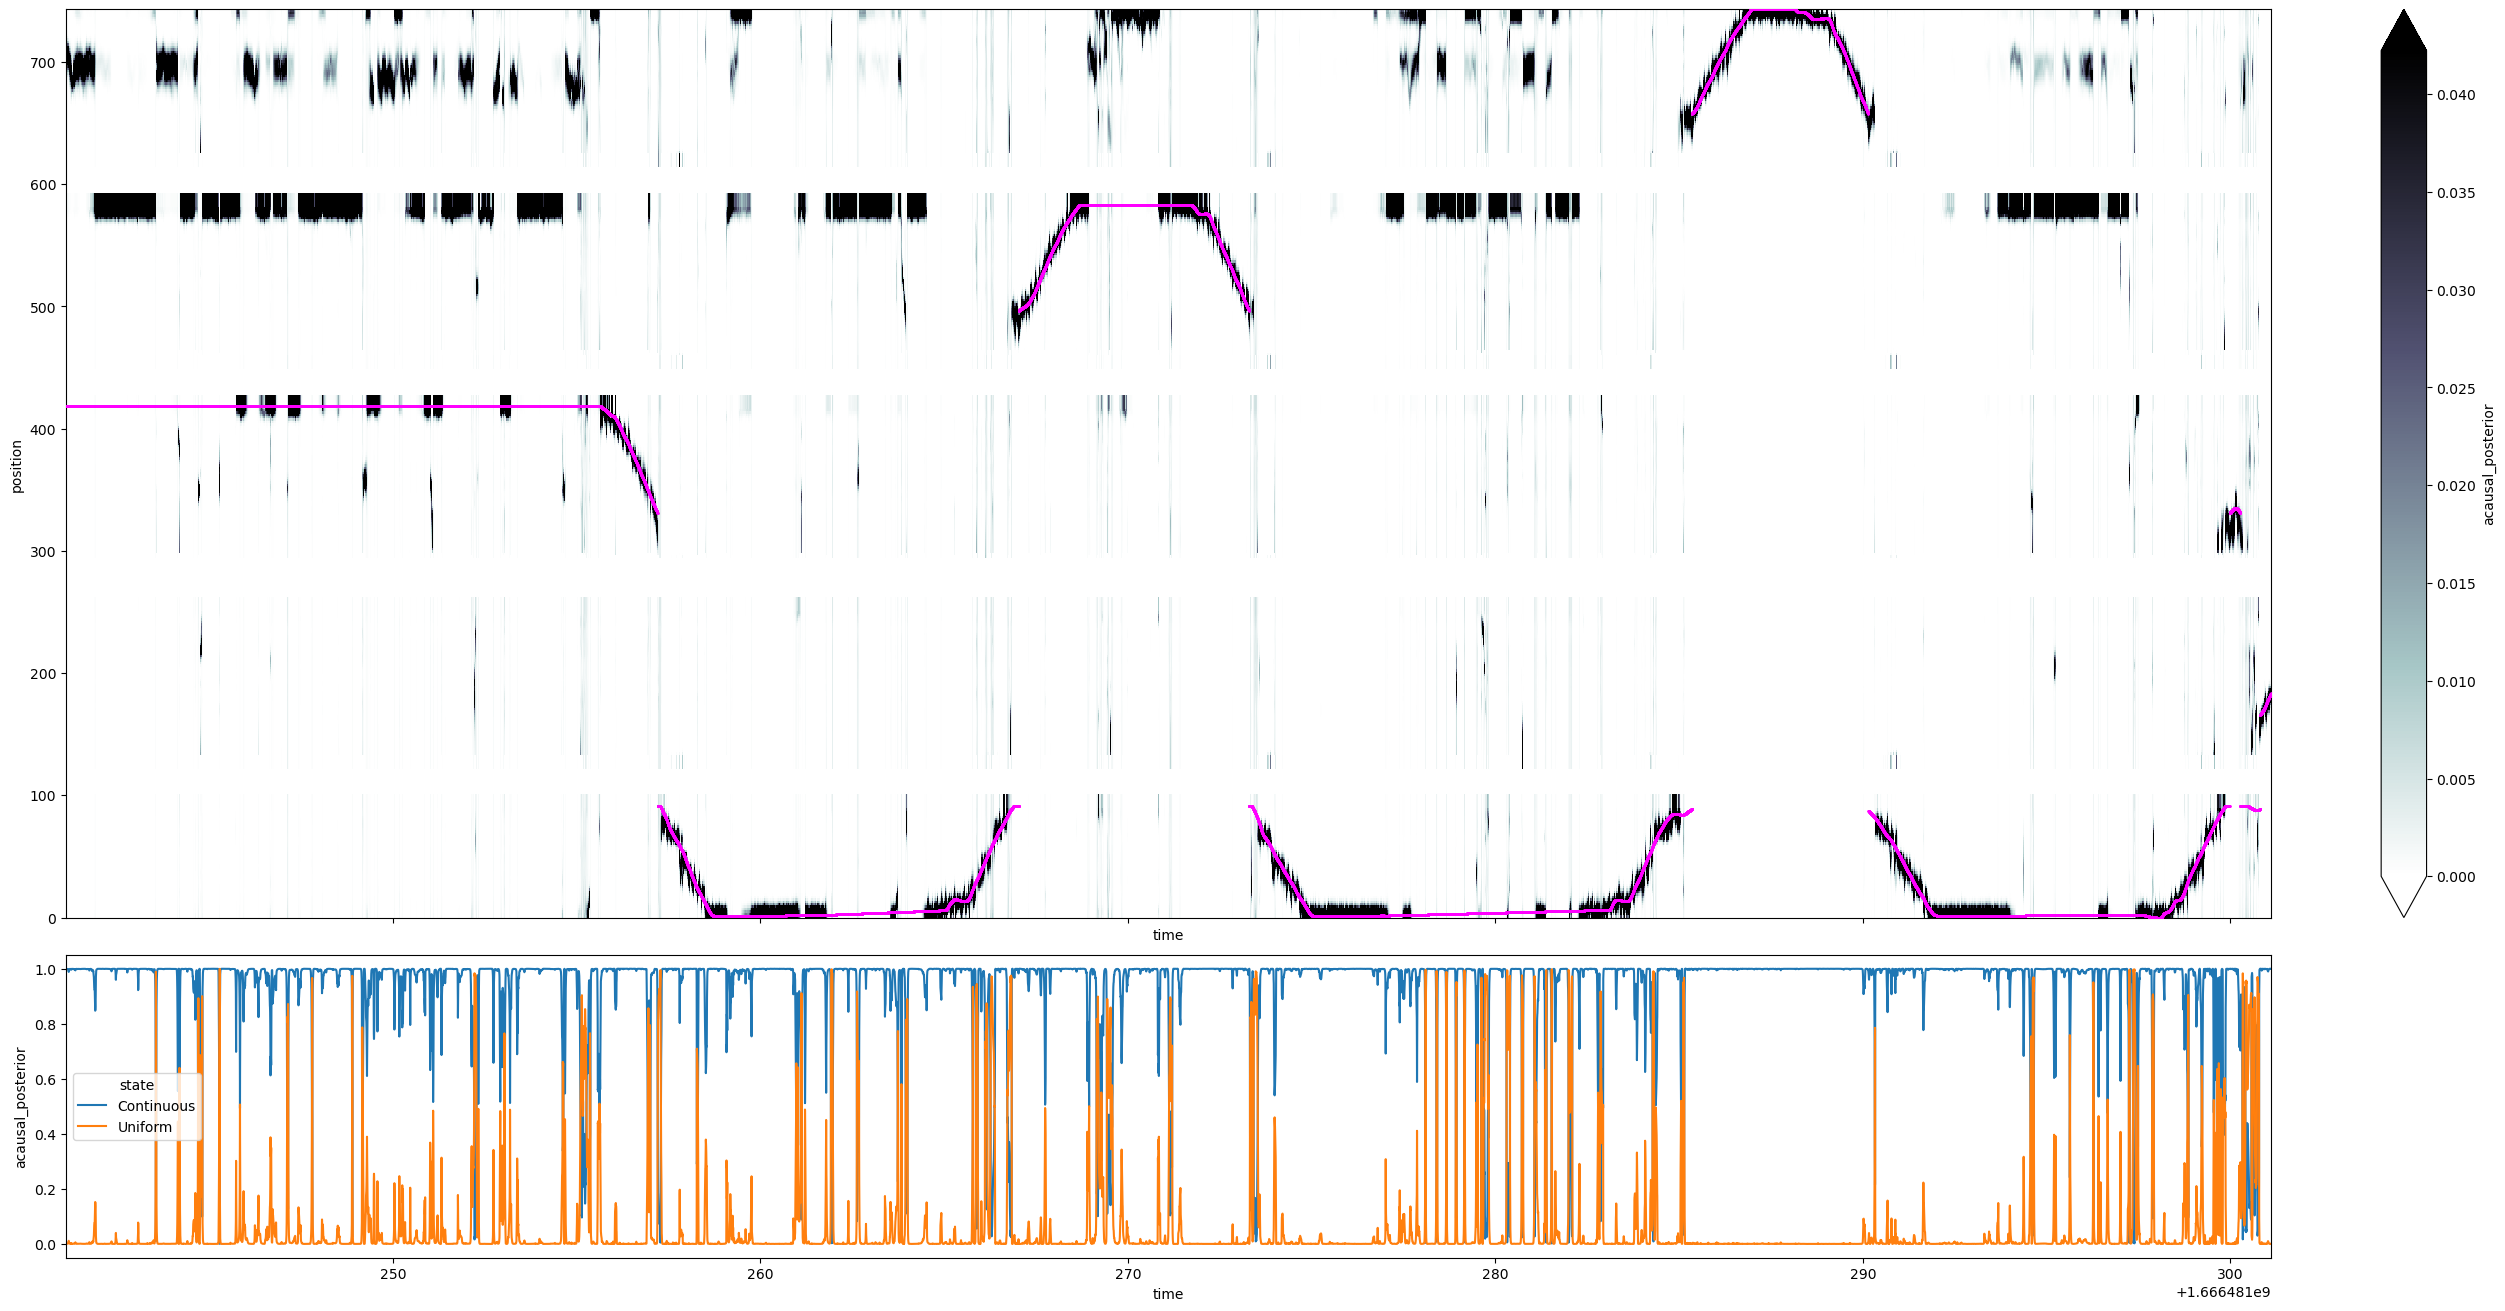

In [90]:
import matplotlib.pyplot as plt
for time_ind in range(0, 100_000, 10_000): #range(0, 600_000, 100_000)
    time_slice = slice(time_ind, time_ind + 30_000)

    fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)
    results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
    axes[0].scatter(position_1d.iloc[time_slice].time,
                    position_1d.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)
 
    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

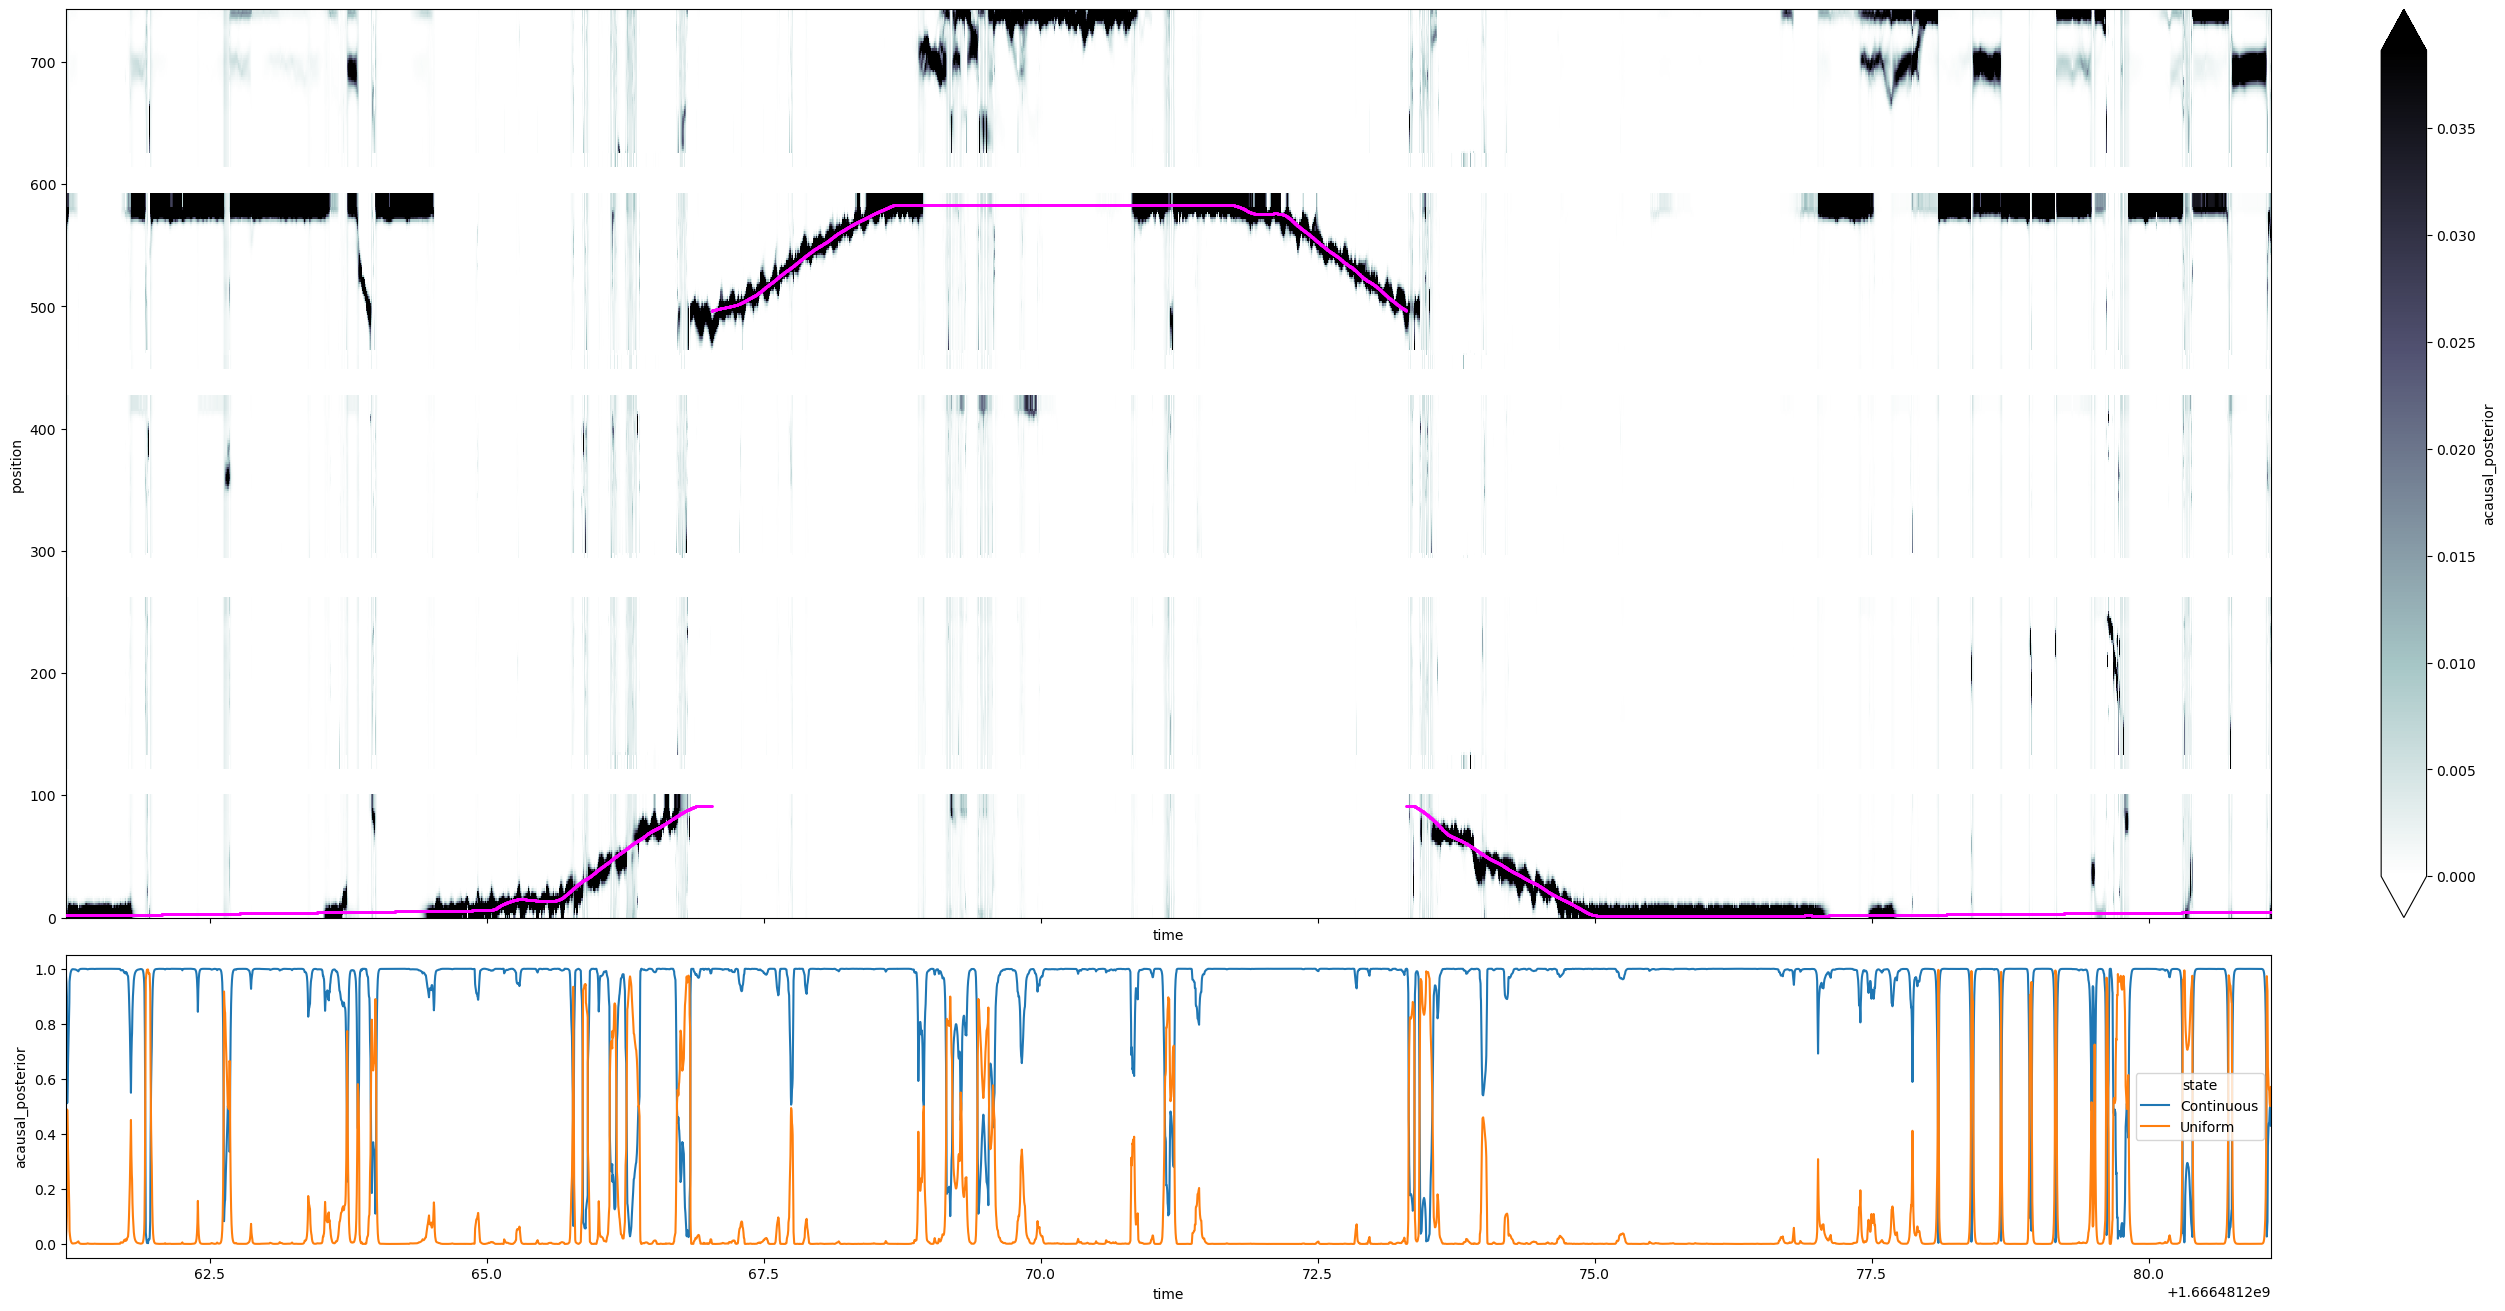

In [91]:
import matplotlib.pyplot as plt

time_slice = slice(100_050, 110_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

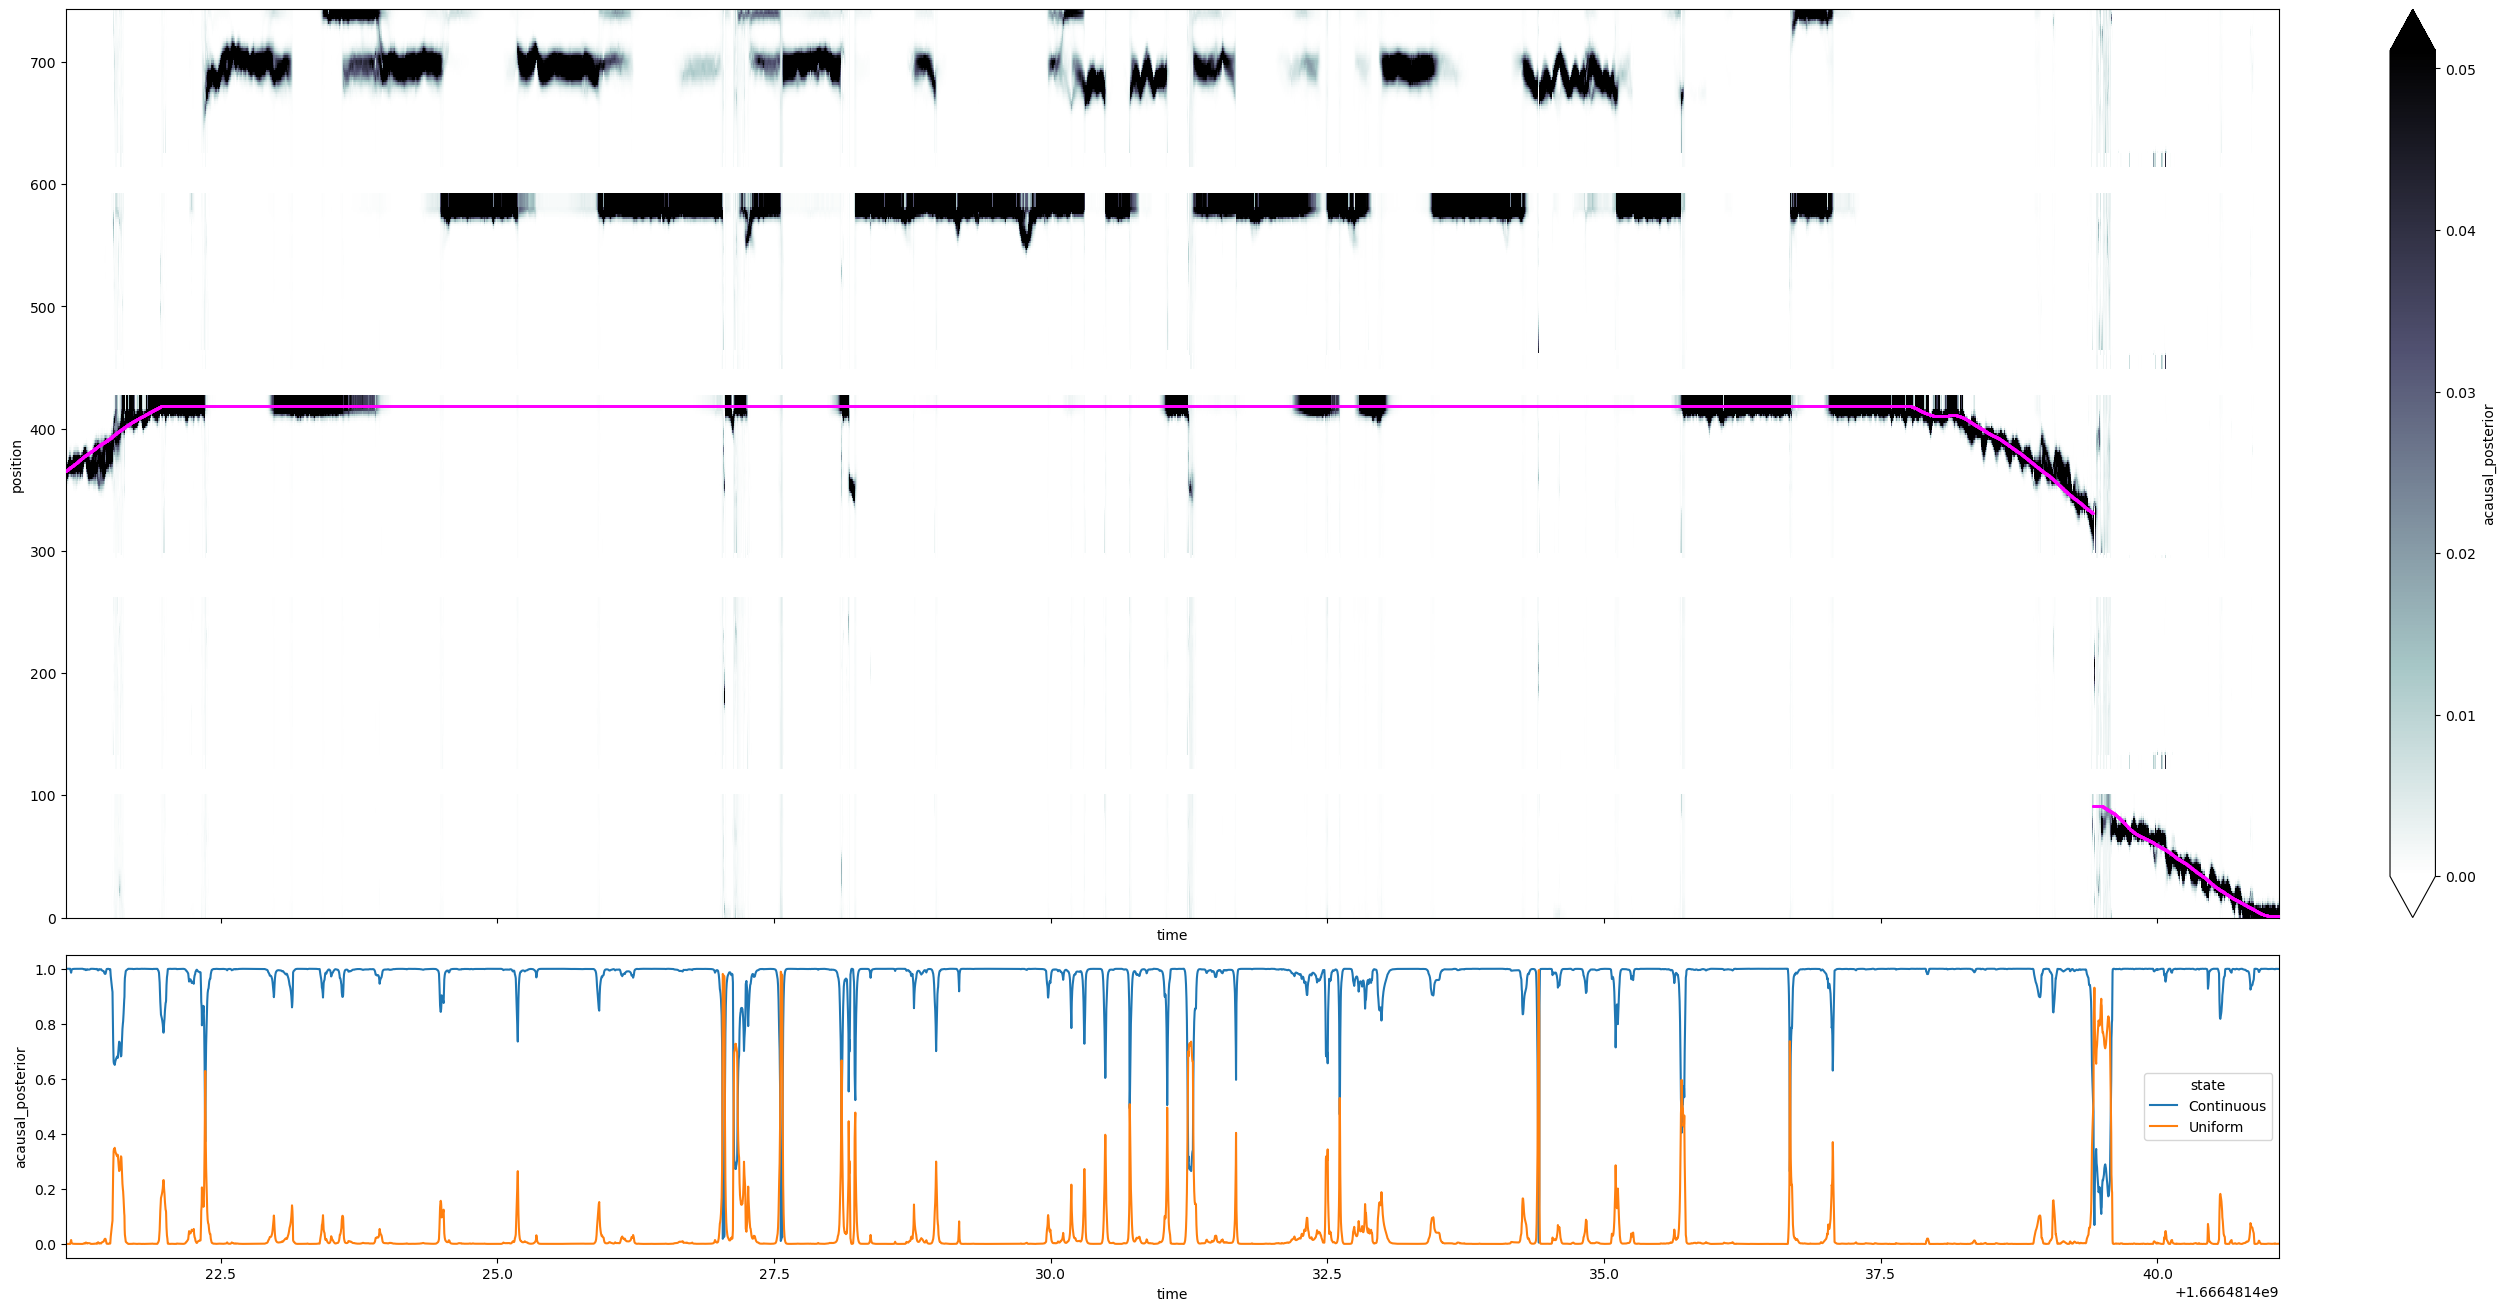

In [92]:
import matplotlib.pyplot as plt

time_slice = slice(180_000, 190_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

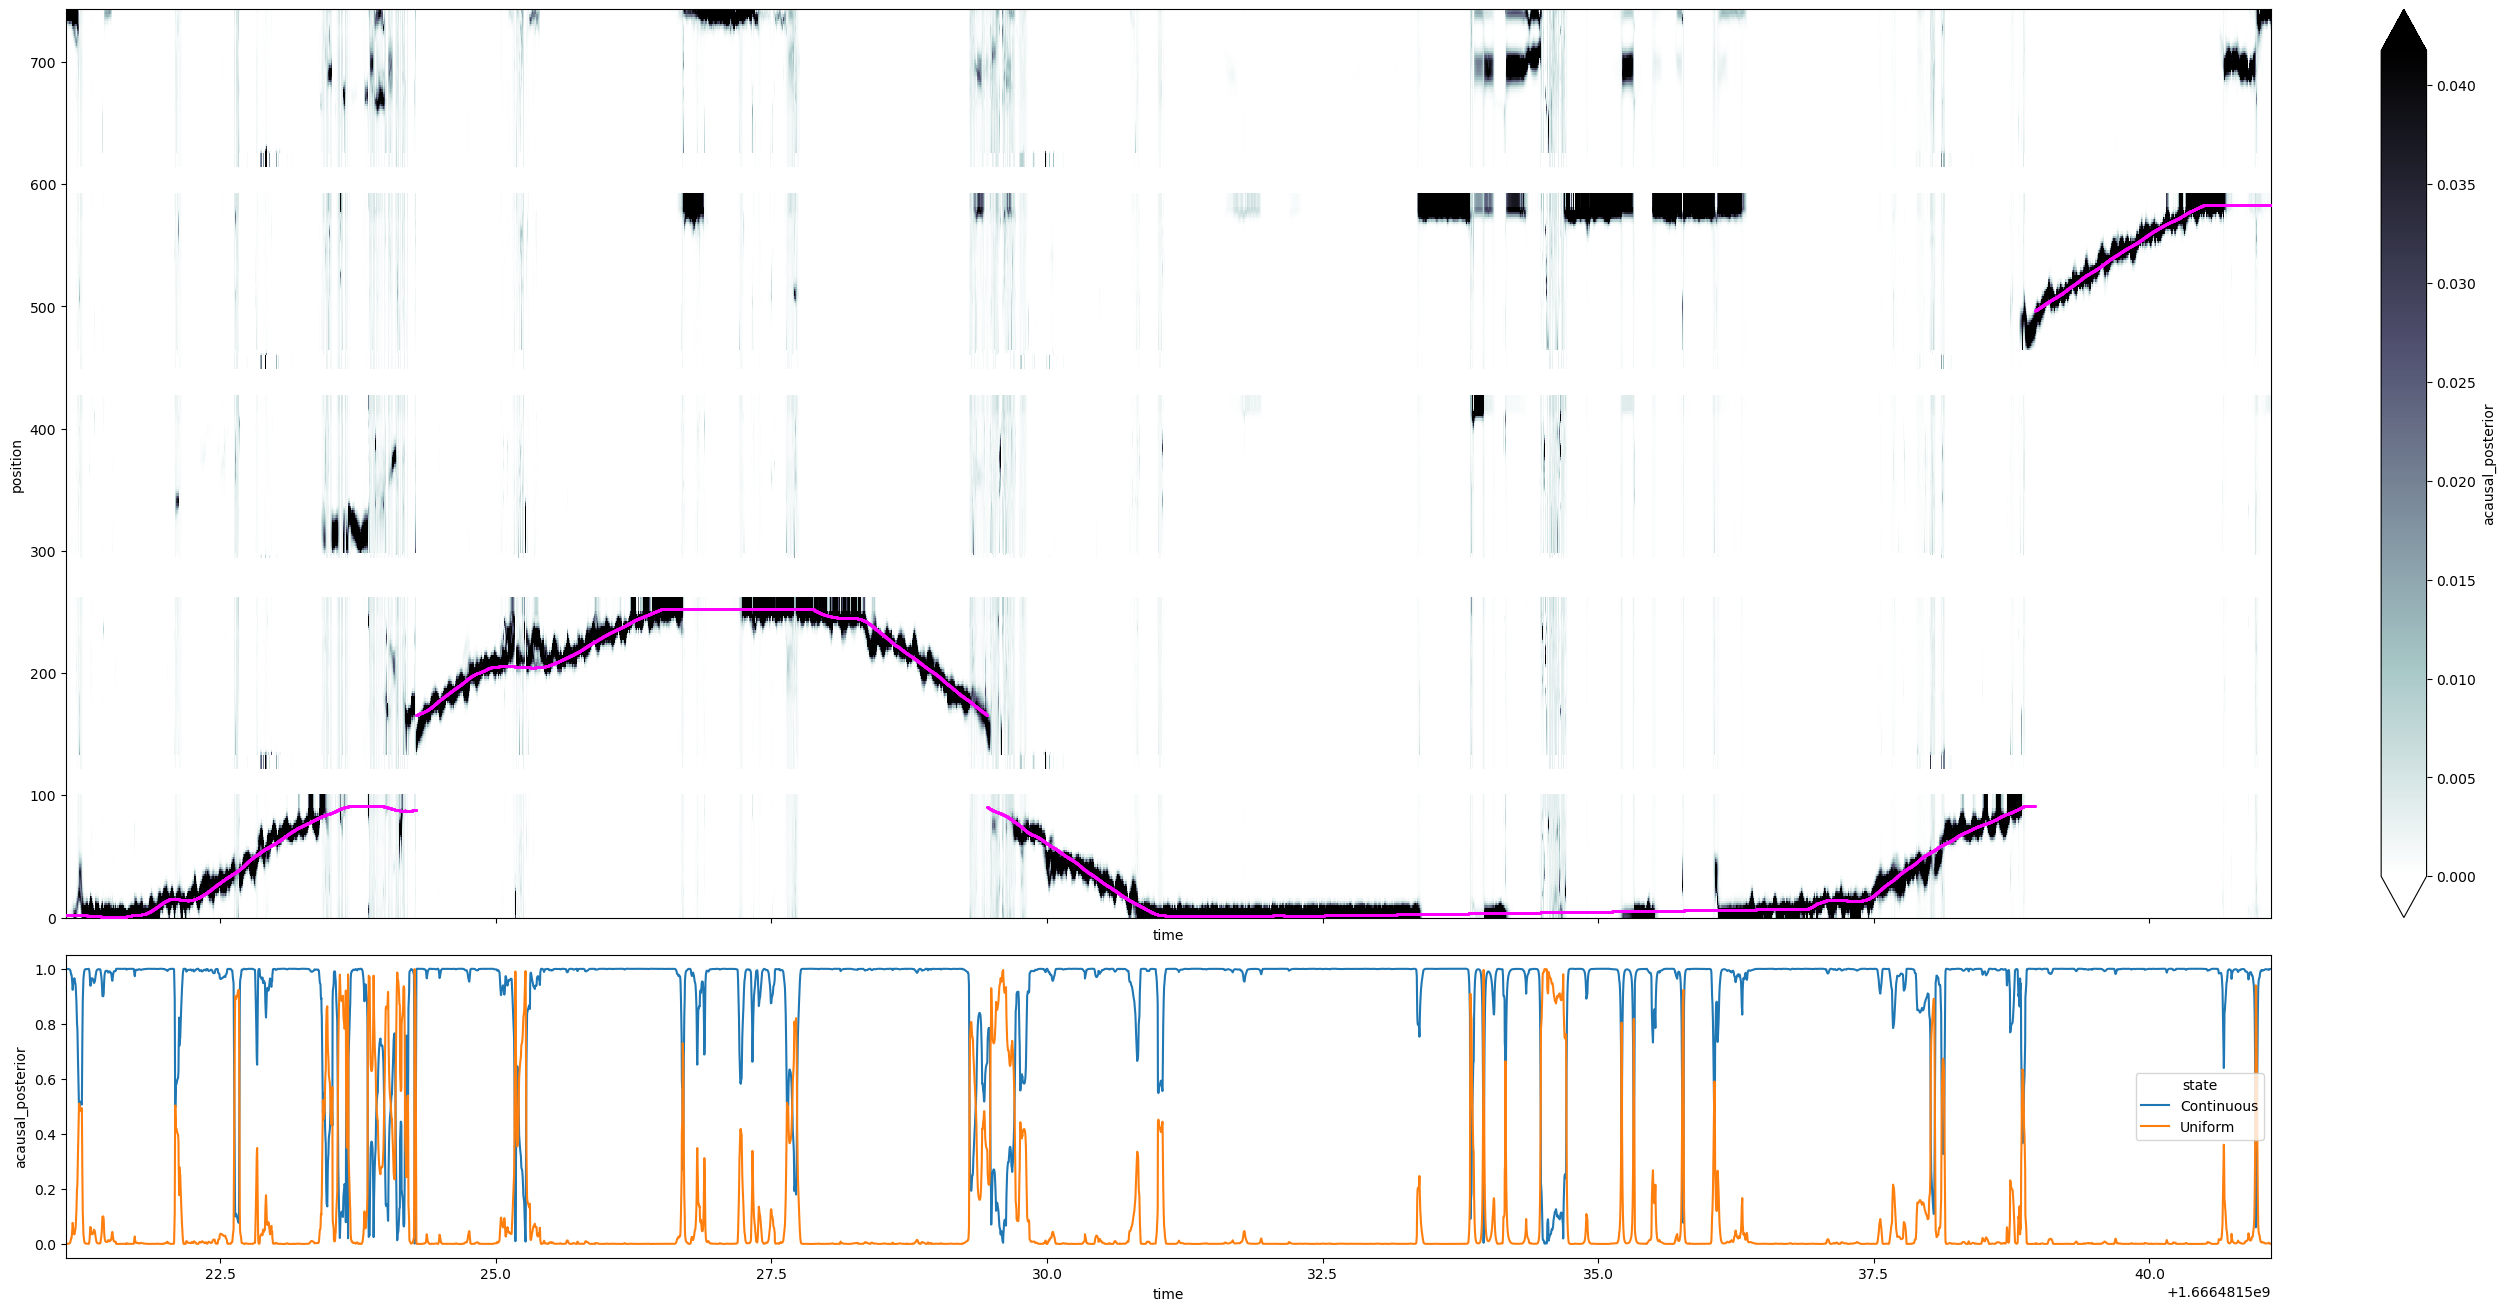

In [94]:
import matplotlib.pyplot as plt

time_slice = slice(230_000, 240_000)

fig, axes = plt.subplots(2, 1, figsize=(25, 13), sharex=True, constrained_layout=True, gridspec_kw={"height_ratios": [3, 1]},)

results.isel(time=time_slice).acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[0], robust=True, cmap='bone_r')
axes[0].scatter(position_1d.iloc[time_slice].time,
                position_1d.iloc[time_slice].linear_position.values,
                s=1, color='magenta', zorder=10)

results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

# For all sessions

In [91]:
from trajectory_analysis_tools import get_trajectory_data, get_ahead_behind_distance

trajectory_data = get_trajectory_data(
    results.sum('state').acausal_posterior,
    track_graph,
    classifier,
    linear_position_df[['projected_x_position', 'projected_y_position']],
    linear_position_df.track_segment_id,
    position_info.head_orientation,
)

ahead_behind_distance = get_ahead_behind_distance(
    track_graph, *trajectory_data)
mental_position_edges = trajectory_data[-1]
mental_position_edge_id = np.asarray(
    [track_graph.edges[edge]['edge_id'] for edge in mental_position_edges])

NameError: name 'position_info' is not defined

In [30]:
from ripple_detection import get_multiunit_population_firing_rate

SAMPLING_FREQUENCY = 500

multiunit_spikes = (np.any(~np.isnan(marks.values), axis=1)
                    ).astype(float)
multiunit_firing_rate = pd.DataFrame(
    get_multiunit_population_firing_rate(
        multiunit_spikes, SAMPLING_FREQUENCY), index=marks.time,
    columns=['firing_rate'])

In [31]:
from ripple_detection import multiunit_HSE_detector

multiunit_high_synchrony_times = multiunit_HSE_detector(
    marks.time.values,
    multiunit_spikes,
    position_info.head_speed.values,
    sampling_frequency=SAMPLING_FREQUENCY,
    minimum_duration=0.015,
    zscore_threshold=2.0,
    close_event_threshold=0.000)

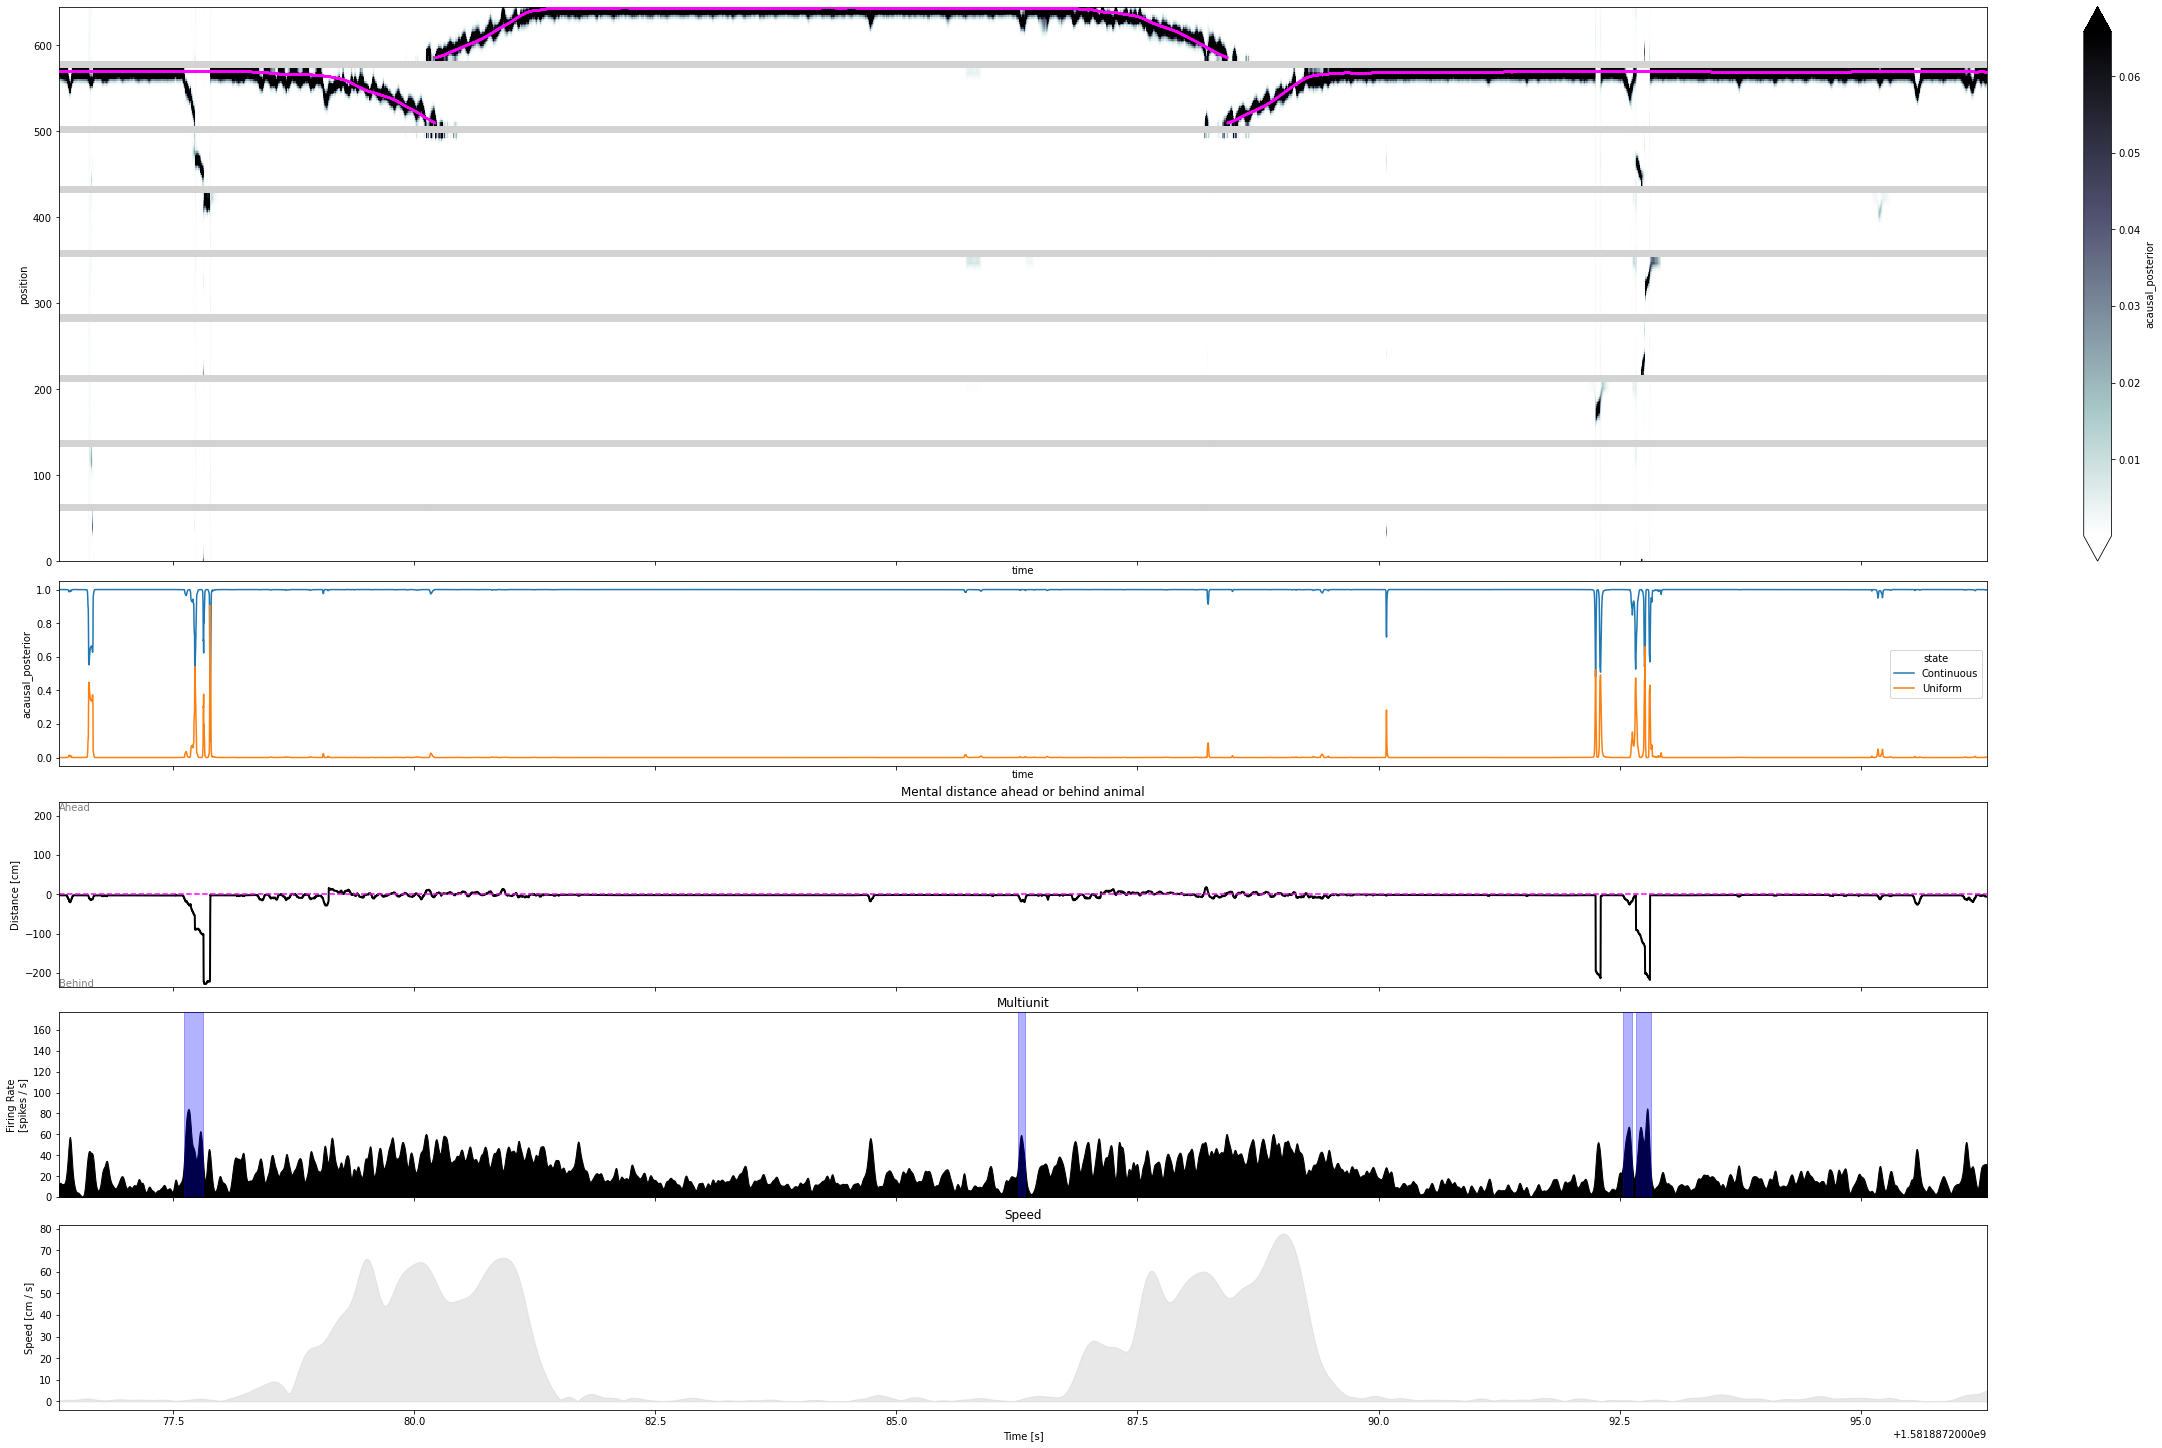

In [32]:
import matplotlib.pyplot as plt
import copy


def plot_classifier(
    time_slice,
    results,
    classifier,
    position_info,
    linear_position_df,
    ahead_behind_distance,
    multiunit_firing_rate,
    multiunit_high_synchrony_times,
    cmap='bone_r',
    figsize=(30, 20)
):

    cmap = copy.copy(plt.cm.get_cmap(cmap))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    fig, axes = plt.subplots(5, 1, figsize=figsize, sharex=True, constrained_layout=True,
                             gridspec_kw={"height_ratios": [3, 1, 1, 1, 1]},)

    time = results.isel(time=time_slice).time
    (results
     .isel(time=time_slice)
     .acausal_posterior
     .sum('state')
     .where(classifier.environments[0].is_track_interior_)
     .plot(x='time', y='position', ax=axes[0], robust=True, cmap=cmap))
    axes[0].scatter(time,
                    linear_position_df.iloc[time_slice].linear_position.values,
                    s=1, color='magenta', zorder=10)

    results.isel(time=time_slice).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])
    axes[2].plot(time,
                 ahead_behind_distance[time_slice],
                 color="black", linewidth=2)
    axes[2].axhline(0, color="magenta", linestyle="--")
    axes[2].set_title("Mental distance ahead or behind animal")
    axes[2].set_ylabel("Distance [cm]")
    max_dist = np.max(np.abs(ahead_behind_distance)) + 5
    axes[2].set_ylim((-max_dist, max_dist))
    axes[2].text(time[0], max_dist - 1, "Ahead", color="grey", va='top')
    axes[2].text(time[0], -max_dist + 1, "Behind", color="grey")

    # ax 3
    axes[3].fill_between(
        multiunit_firing_rate.iloc[time_slice].index.values,
        multiunit_firing_rate.iloc[time_slice].values.squeeze(),
        color="black",
    )
    axes[3].set_ylabel("Firing Rate\n[spikes / s]")
    axes[3].set_title("Multiunit")
    axes[3].set_ylim((0.0, np.max(np.asarray(multiunit_firing_rate))))


    cur_multiunit_HSE = interval_list_intersect(
        np.asarray(multiunit_high_synchrony_times),
        np.asarray([(time[0], time[-1])]))

    for start_time, end_time in cur_multiunit_HSE:
        axes[3].axvspan(start_time, end_time, color='blue', alpha=0.3, zorder=10)

    # ax 4
    axes[4].fill_between(
        time,
        position_info.iloc[time_slice]
        .head_speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[4].set_title('Speed')
    axes[4].set_ylabel("Speed [cm / s]")
    axes[4].set_xlabel("Time [s]")
    

time_slice = slice(180_000, 190_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

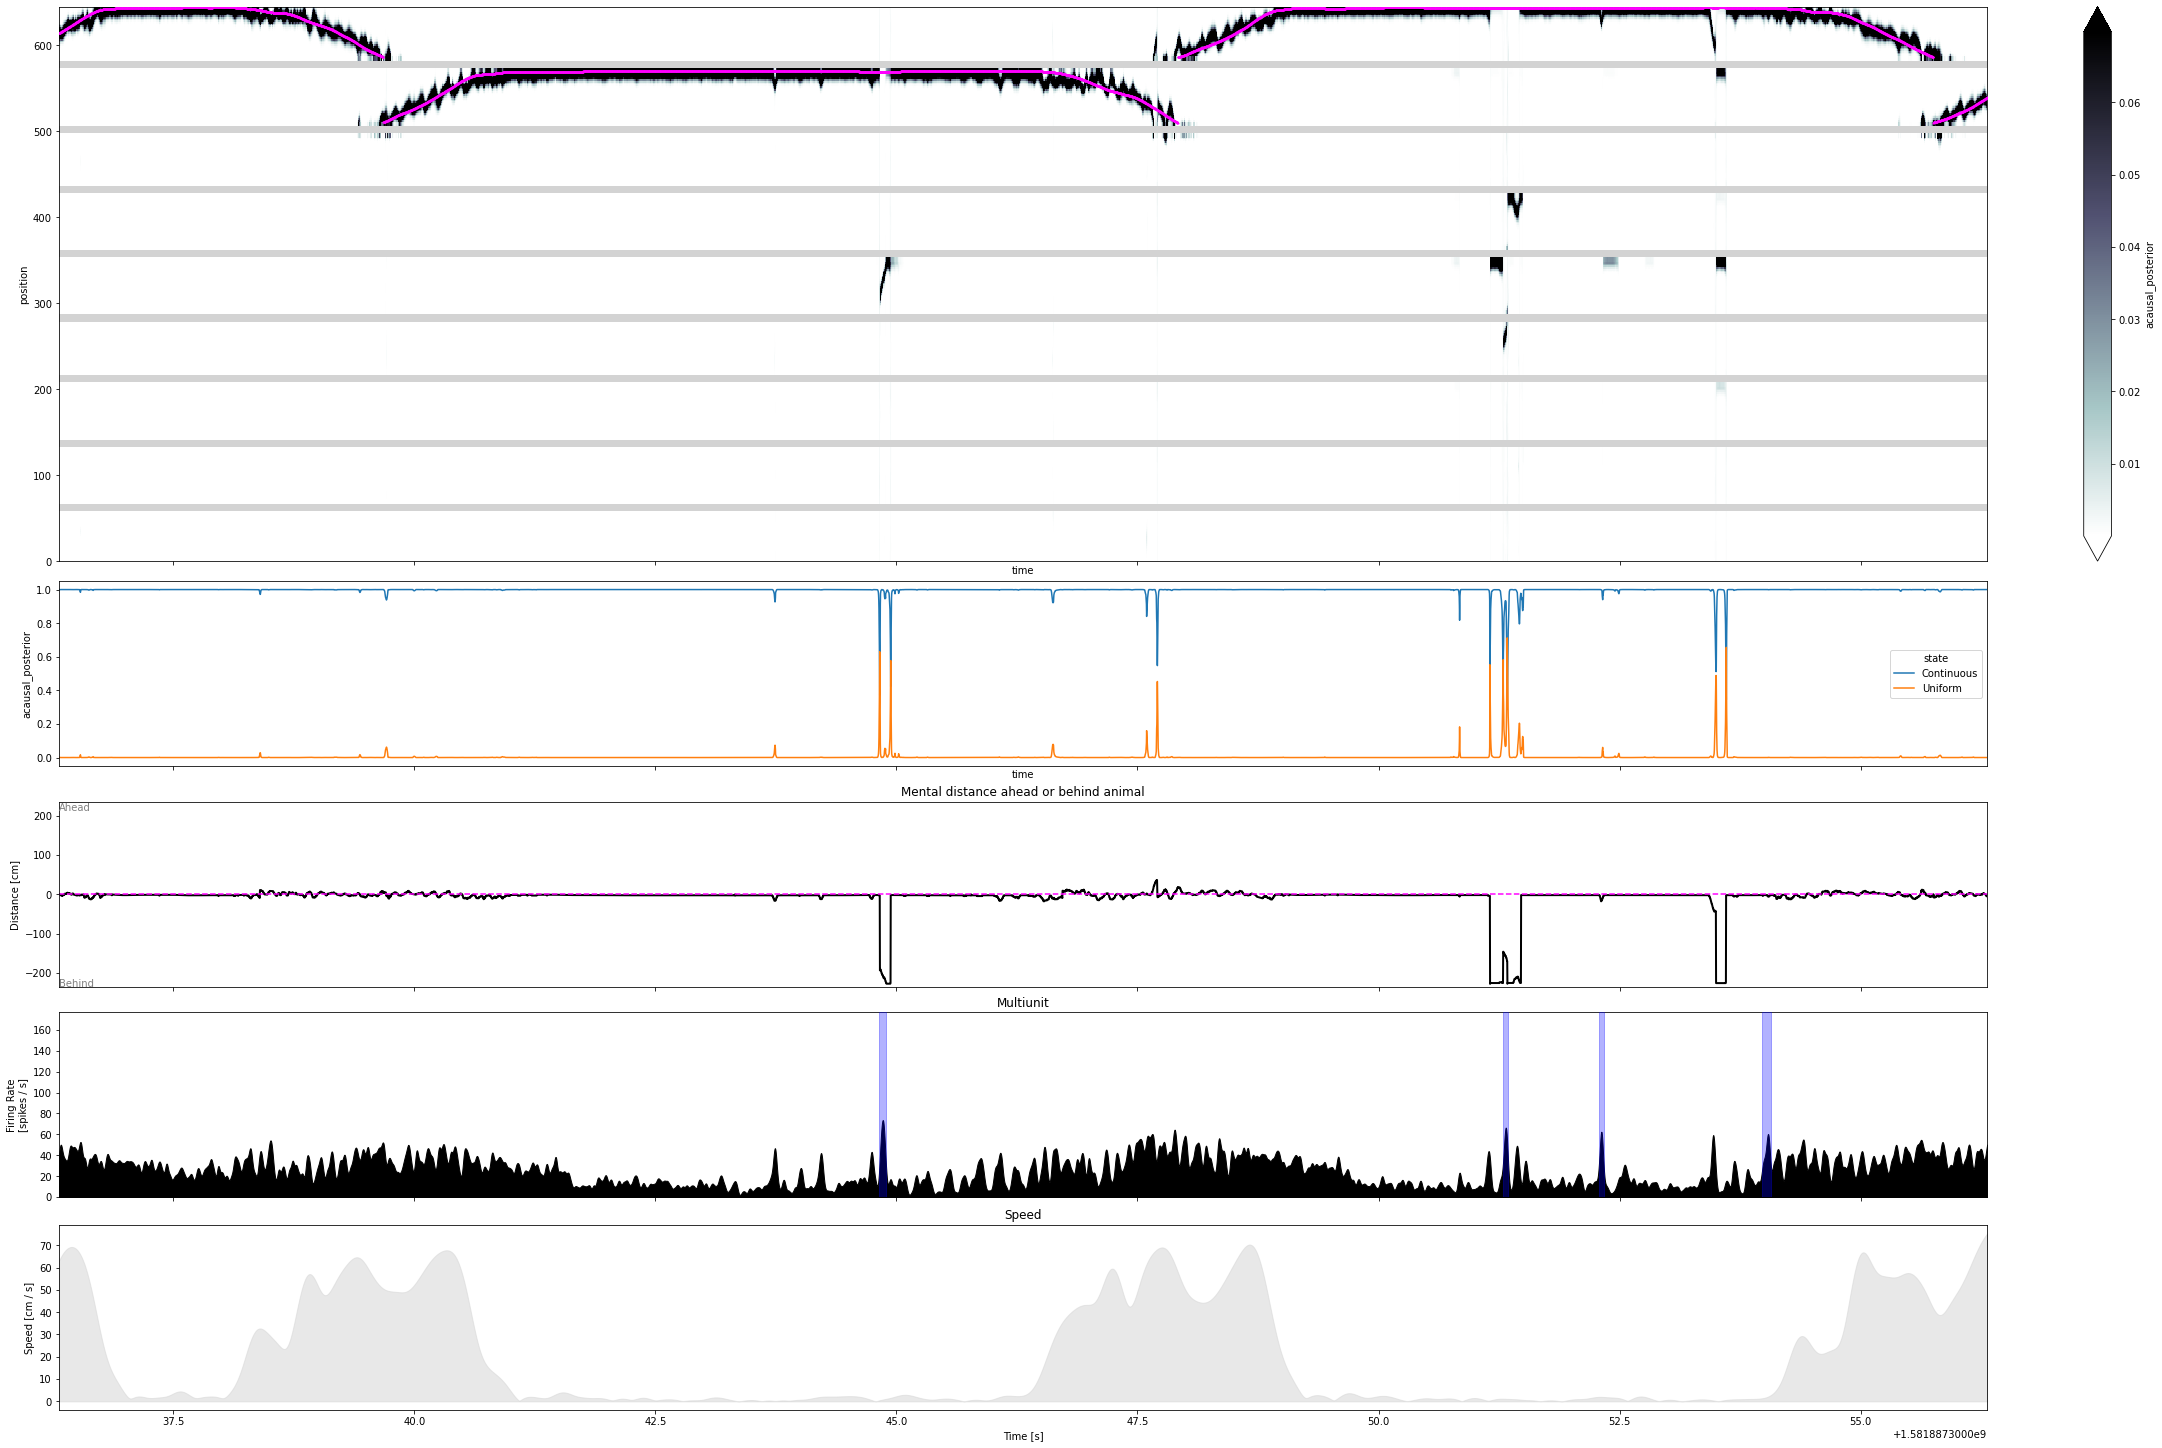

In [33]:
time_slice = slice(210_000, 220_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)

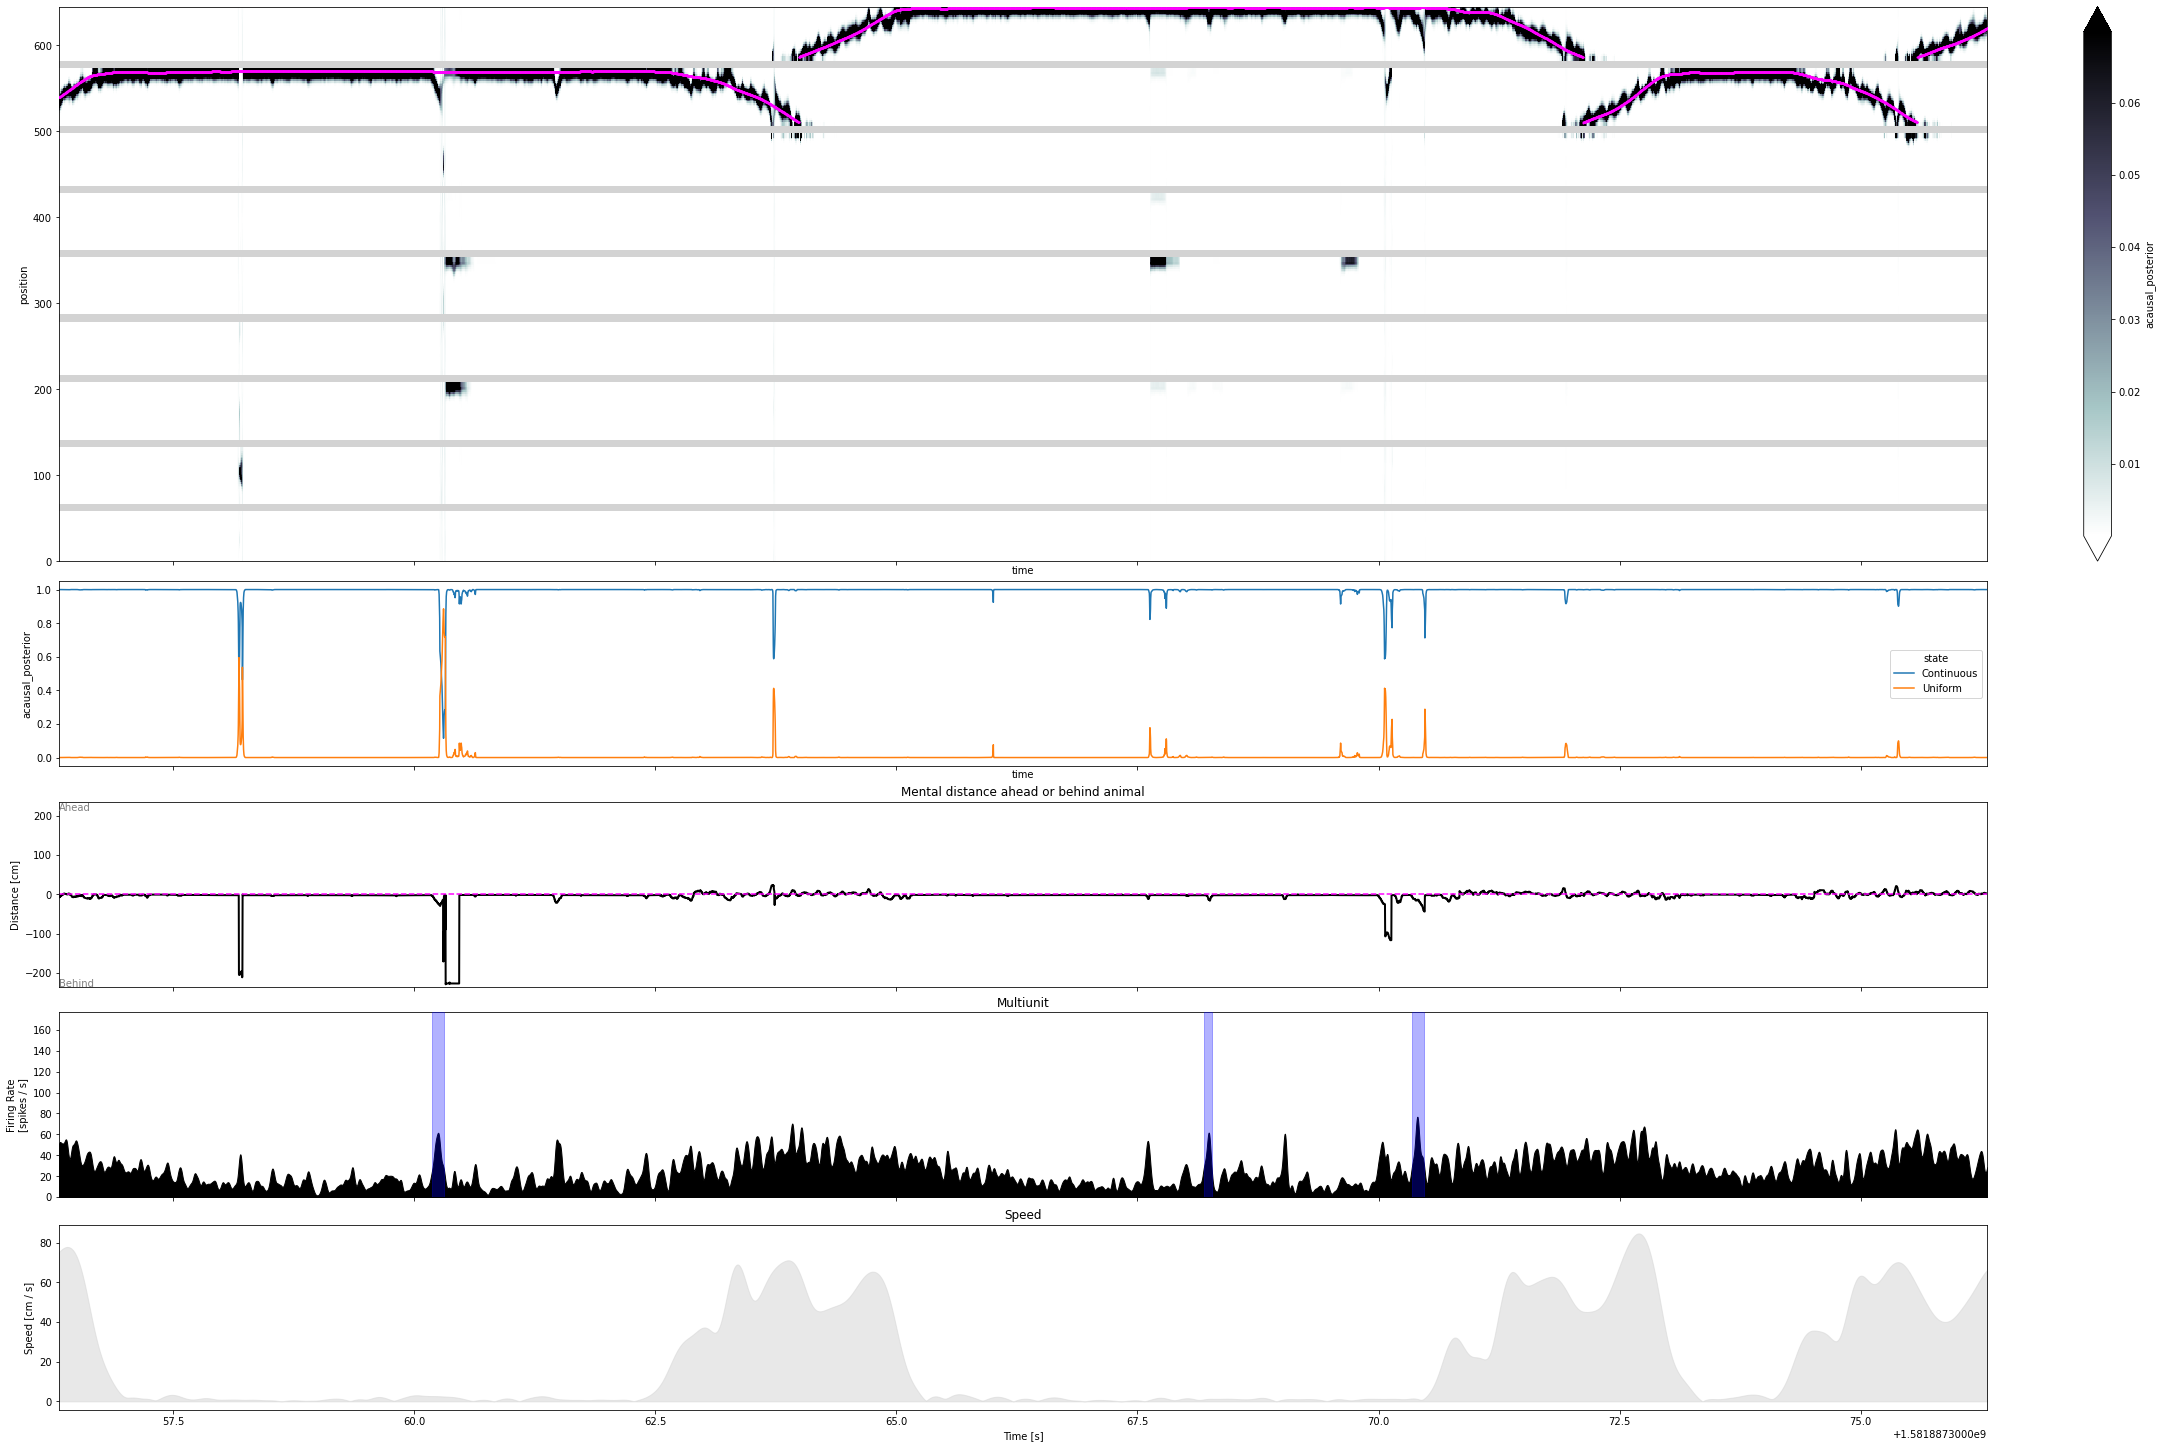

In [34]:
time_slice = slice(220_000, 230_000)
plot_classifier(time_slice, results, classifier, position_info, linear_position_df, ahead_behind_distance,
                multiunit_firing_rate, multiunit_high_synchrony_times)